##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub를 사용한 Bangla 문서 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

주의: pip로 python 패키지를 설치하는 외에도 이 노트북에서는 `sudo apt install`을 사용하여 시스템 패키지`unzip`을 설치합니다.

이 colab은 비 영어/현지어로 텍스트를 분류하기 위해 [Tensorflow Hub](https://www.tensorflow.org/hub/)를 사용하는 데모입니다. 여기에서는 [Bangla](https://en.wikipedia.org/wiki/Bengali_language)를 현지어로 선택하고 사전 훈련된 단어 임베딩을 사용하여 Bangla 뉴스 기사를 5가지 범주로 분류하는 다중 클래스 분류 작업을 해결합니다. Bangla용 사전 훈련 임베딩은 157개 언어에 대해 사전 훈련된 단어 벡터를 게시한 Facebook 라이브러리인 [fastText](https://fasttext.cc/docs/en/crawl-vectors.html)에서 가져옵니다.

먼저 TF-Hub의 사전 훈련된 임베딩 exporter를 사용하여 단어 임베딩을 텍스트 임베딩 모듈로 변환한 다음, Tensorflow의 사용자 친화적인 상위 수준 API인 [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)로 분류자를 훈련하는 모듈을 사용하여 딥 러닝 모델을 빌드합니다. 여기에서 fastText 임베딩을 사용하더라도 다른 작업에서 사전 훈련된 다른 임베딩을 내보내고 Tensorflow Hub를 사용하여 신속하게 결과를 얻을 수 있습니다. 

## 설정

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install gdown --no-use-pep517

  Using cached filelock-3.8.2-py3-none-any.whl (10 kB)


In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...


Building dependency tree...


Reading state information...


unzip is already the newest version (6.0-25ubuntu1.1).


The following packages were automatically installed and are no longer required:


  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2


  libparted-fs-resize0


Use 'sudo apt autoremove' to remove them.


0 upgraded, 0 newly installed, 0 to remove and 170 not upgraded.


In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2022-12-14 22:32:00.433726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:32:00.433836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:32:00.433847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# 데이터세트

다양한 Bangla 뉴스 포털에서 수집한 약 3,76,226개의 기사가 있고 경제, 국내, 국제, 스포츠 및 엔터테인먼트의 5가지 범주로 분류된 [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)(Bangla Article Dataset)를 사용합니다. 이 ([bit.ly/BARD_DATASET](bit.ly/BARD_DATASET)) 링크가 가리키는 Google 드라이브 파일을 [이](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub 리포지토리에서 다운로드합니다.


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# 사전 훈련된 단어 벡터를 TF-Hub 모듈로 내보내기

TF-Hub는 [여기](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2)에서 단어 임베딩을 TF-Hub 텍스트 임베딩 모듈로 변환하기 위한 몇 가지 유용한 스크립트를 제공합니다. Bangla 또는 다른 언어 모듈을 만들려면 임베딩 단어 `.txt` 또는 `.vec` 파일을 `export_v2.py`와 동일한 디렉터리로 다운로드하고 스크립트를 실행하기만 하면 됩니다.

Exporter는 임베딩 벡터를 읽고 Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model)로 내보냅니다. SavedModel에는 가중치와 그래프를 포함한 완전한 TensorFlow 프로그램이 포함되어 있습니다. TF-Hub는 SavedModel을 텍스트 분류를 위한 모델을 빌드하는 데 사용할 [모듈](https://www.tensorflow.org/hub/api_docs/python/hub/Module)로 로드할 수 있습니다. 모델을 빌드하기 위해 `tf.keras`를 사용하므로 TF-Hub 모듈이 Keras 레이어로 사용할 래퍼를 제공하는 [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer)를 사용할 것입니다.

먼저 fastText에서 단어 임베딩을 가져오고 TF-Hub [리포지토리](https://github.com/tensorflow/hub)에서 임베딩 exporter를 가져옵니다.


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  840M  100  840M    0     0  35.2M      0  0:00:23  0:00:23 --:--:-- 38.2M


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100  7469  100  7469    0     0  45542      0 --:--:-- --:--:-- --:--:-- 45542


그런 다음 임베딩 파일에서 Exporter 스크립트를 실행합니다. fastText 임베딩에는 헤더 행이 있고 크기가 상당히 크기 때문에(모듈로 변환한 후 Bangla의 경우 약 3.3GB) 첫 번째 행을 무시하고 처음 100,000개의 토큰만 텍스트 임베딩 모듈로 내보냅니다.

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2022-12-14 22:33:22.833612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory


2022-12-14 22:33:22.833707: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory


2022-12-14 22:33:22.833717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


INFO:tensorflow:Assets written to: text_module/assets


I1214 22:33:38.019392 140325052233536 builder_impl.py:797] Assets written to: text_module/assets


In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

텍스트 임베딩 모듈은 문자열의 1D 텐서에 있는 문장 배치를 입력으로 받아 문장에 해당하는 형상의 임베딩 벡터(batch_size, embedding_dim)를 출력합니다. 공백으로 분할하여 입력을 전처리합니다. 단어 임베딩은 `sqrtn` sqrtn combiner를 사용하여 문장 임베딩에 결합됩니다([여기](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse) 참조). 데모를 위해 Bangla 단어 목록을 입력으로 전달하고 해당 임베딩 벡터를 얻습니다.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Tensorflow 데이터세트로 변환하기


데이터세트가 정말 크기 때문에 메모리에 전체 데이터세트를 로드하는 대신 [Tensorflow 데이터세트](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 기능을 사용하여 일괄적으로 런타임에 샘플을 생성하는 데 생성기를 사용합니다. 데이터세트는 또한 매우 불균형적이므로 생성기를 사용하기 전에 데이터세트를 셔플합니다.


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

셔플한 후 훈련 및 검증 예제에서 레이블 분포를 확인할 수 있습니다.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

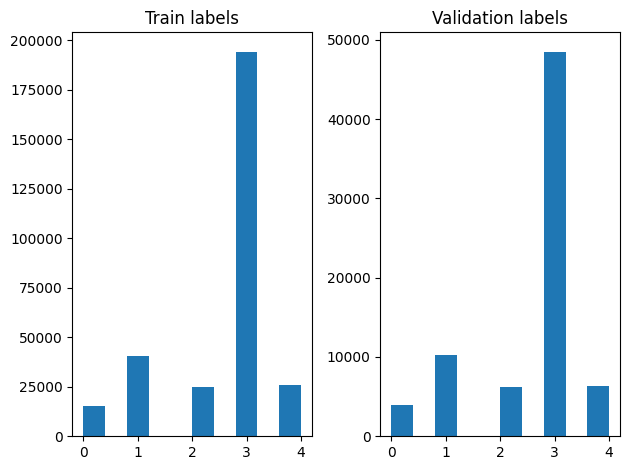

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

생성기를 사용하여 [데이터세트](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)를 생성하려면 먼저 `file_paths`에서 각 기사를 읽고 레이블 배열에서 레이블을 읽어 각 스텝에서 하나의 훈련 예제를 생성하는 생성기 함수를 작성합니다. 이 생성기 함수를 [`tf.data.Dataset.from_generator`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) 메서드에 전달하고 출력 유형을 지정합니다. 각 훈련 예제는 `tf.string` 데이터 형식의 기사와 원-핫 인코딩된 레이블을 포함하는 튜플입니다. [`tf.data.Dataset.skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) 및 [`tf.data.Dataset.take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) 메서드를 사용하여 80-20의 훈련-검증 분할로 데이터세트를 분할합니다.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# 모델 훈련 및 평가

keras에서 다른 레이어로 사용하기 위해 모듈 주위에 래퍼를 이미 추가했으므로 레이어의 선형 스택인 작은 [순차](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) 모델을 만들 수 있습니다. 다른 레이어와 마찬가지로 `model.add`로 텍스트 임베딩 모듈을 추가할 수 있습니다. 손실과 옵티마이저를 지정하여 모델을 컴파일하고 10개 epoch 동안 훈련합니다. `tf.keras` API는 Tensorflow 데이터세트를 입력으로 처리할 수 있으므로 모델 훈련을 위해 데이터세트 인스턴스를 fit 메서드로 전달할 수 있습니다. 생성기 함수를 사용하기 때문에 `tf.data`가 샘플을 생성하고 배치 처리하여 모델에 공급하는 작업을 처리합니다.

## 모델

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## 훈련

In [19]:
history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5


   1/1176 [..............................] - ETA: 37:08 - loss: 1.6128 - accuracy: 0.1055

   4/1176 [..............................] - ETA: 24s - loss: 1.4565 - accuracy: 0.4570  

   7/1176 [..............................] - ETA: 23s - loss: 1.3762 - accuracy: 0.5268

  10/1176 [..............................] - ETA: 22s - loss: 1.3160 - accuracy: 0.5566

  13/1176 [..............................] - ETA: 22s - loss: 1.2741 - accuracy: 0.5727

  16/1176 [..............................] - ETA: 22s - loss: 1.2397 - accuracy: 0.5830

  19/1176 [..............................] - ETA: 22s - loss: 1.1992 - accuracy: 0.5952

  22/1176 [..............................] - ETA: 22s - loss: 1.1641 - accuracy: 0.6014

  25/1176 [..............................] - ETA: 22s - loss: 1.1318 - accuracy: 0.6061

  28/1176 [..............................] - ETA: 21s - loss: 1.1019 - accuracy: 0.6154

  31/1176 [..............................] - ETA: 21s - loss: 1.0746 - accuracy: 0.6251

  34/1176 [..............................] - ETA: 21s - loss: 1.0440 - accuracy: 0.6378

  37/1176 [..............................] - ETA: 21s - loss: 1.0189 - accuracy: 0.6467

  40/1176 [>.............................] - ETA: 21s - loss: 0.9976 - accuracy: 0.6536

  43/1176 [>.............................] - ETA: 21s - loss: 0.9738 - accuracy: 0.6611

  46/1176 [>.............................] - ETA: 21s - loss: 0.9534 - accuracy: 0.6693

  49/1176 [>.............................] - ETA: 21s - loss: 0.9324 - accuracy: 0.6771

  52/1176 [>.............................] - ETA: 21s - loss: 0.9111 - accuracy: 0.6849

  55/1176 [>.............................] - ETA: 21s - loss: 0.8901 - accuracy: 0.6925

  58/1176 [>.............................] - ETA: 21s - loss: 0.8702 - accuracy: 0.7002

  61/1176 [>.............................] - ETA: 21s - loss: 0.8526 - accuracy: 0.7070

  65/1176 [>.............................] - ETA: 21s - loss: 0.8288 - accuracy: 0.7161

  68/1176 [>.............................] - ETA: 20s - loss: 0.8117 - accuracy: 0.7227

  71/1176 [>.............................] - ETA: 20s - loss: 0.7977 - accuracy: 0.7278

  74/1176 [>.............................] - ETA: 20s - loss: 0.7819 - accuracy: 0.7335

  77/1176 [>.............................] - ETA: 20s - loss: 0.7687 - accuracy: 0.7387

  80/1176 [=>............................] - ETA: 20s - loss: 0.7538 - accuracy: 0.7450

  83/1176 [=>............................] - ETA: 20s - loss: 0.7395 - accuracy: 0.7508

  86/1176 [=>............................] - ETA: 20s - loss: 0.7260 - accuracy: 0.7556

  89/1176 [=>............................] - ETA: 20s - loss: 0.7120 - accuracy: 0.7609

  92/1176 [=>............................] - ETA: 20s - loss: 0.6977 - accuracy: 0.7661

  95/1176 [=>............................] - ETA: 20s - loss: 0.6865 - accuracy: 0.7705

  98/1176 [=>............................] - ETA: 20s - loss: 0.6752 - accuracy: 0.7747

 101/1176 [=>............................] - ETA: 20s - loss: 0.6636 - accuracy: 0.7787

 104/1176 [=>............................] - ETA: 20s - loss: 0.6539 - accuracy: 0.7819

 107/1176 [=>............................] - ETA: 20s - loss: 0.6445 - accuracy: 0.7853

 110/1176 [=>............................] - ETA: 20s - loss: 0.6347 - accuracy: 0.7889

 113/1176 [=>............................] - ETA: 20s - loss: 0.6256 - accuracy: 0.7922

 116/1176 [=>............................] - ETA: 19s - loss: 0.6174 - accuracy: 0.7949

 119/1176 [==>...........................] - ETA: 19s - loss: 0.6092 - accuracy: 0.7975

 122/1176 [==>...........................] - ETA: 19s - loss: 0.6011 - accuracy: 0.8001

 125/1176 [==>...........................] - ETA: 19s - loss: 0.5936 - accuracy: 0.8027

 128/1176 [==>...........................] - ETA: 19s - loss: 0.5854 - accuracy: 0.8055

 131/1176 [==>...........................] - ETA: 19s - loss: 0.5780 - accuracy: 0.8081

 134/1176 [==>...........................] - ETA: 19s - loss: 0.5711 - accuracy: 0.8104

 137/1176 [==>...........................] - ETA: 19s - loss: 0.5640 - accuracy: 0.8127

 140/1176 [==>...........................] - ETA: 19s - loss: 0.5575 - accuracy: 0.8148

 143/1176 [==>...........................] - ETA: 19s - loss: 0.5521 - accuracy: 0.8167

 146/1176 [==>...........................] - ETA: 19s - loss: 0.5459 - accuracy: 0.8188

 149/1176 [==>...........................] - ETA: 19s - loss: 0.5392 - accuracy: 0.8209

 152/1176 [==>...........................] - ETA: 19s - loss: 0.5340 - accuracy: 0.8226

 155/1176 [==>...........................] - ETA: 19s - loss: 0.5281 - accuracy: 0.8246

 158/1176 [===>..........................] - ETA: 18s - loss: 0.5231 - accuracy: 0.8265

 161/1176 [===>..........................] - ETA: 18s - loss: 0.5180 - accuracy: 0.8283

 164/1176 [===>..........................] - ETA: 18s - loss: 0.5123 - accuracy: 0.8302

 167/1176 [===>..........................] - ETA: 18s - loss: 0.5077 - accuracy: 0.8318

 170/1176 [===>..........................] - ETA: 18s - loss: 0.5028 - accuracy: 0.8335

 173/1176 [===>..........................] - ETA: 18s - loss: 0.4979 - accuracy: 0.8350

 176/1176 [===>..........................] - ETA: 18s - loss: 0.4937 - accuracy: 0.8363

 179/1176 [===>..........................] - ETA: 18s - loss: 0.4892 - accuracy: 0.8378

 182/1176 [===>..........................] - ETA: 18s - loss: 0.4853 - accuracy: 0.8391

 185/1176 [===>..........................] - ETA: 18s - loss: 0.4812 - accuracy: 0.8405

 188/1176 [===>..........................] - ETA: 18s - loss: 0.4774 - accuracy: 0.8419

 191/1176 [===>..........................] - ETA: 18s - loss: 0.4738 - accuracy: 0.8431

 194/1176 [===>..........................] - ETA: 18s - loss: 0.4701 - accuracy: 0.8444

 197/1176 [====>.........................] - ETA: 18s - loss: 0.4669 - accuracy: 0.8455

 200/1176 [====>.........................] - ETA: 18s - loss: 0.4629 - accuracy: 0.8468

 203/1176 [====>.........................] - ETA: 18s - loss: 0.4591 - accuracy: 0.8481

 206/1176 [====>.........................] - ETA: 17s - loss: 0.4555 - accuracy: 0.8492

 209/1176 [====>.........................] - ETA: 17s - loss: 0.4524 - accuracy: 0.8504

 212/1176 [====>.........................] - ETA: 17s - loss: 0.4490 - accuracy: 0.8517

 215/1176 [====>.........................] - ETA: 17s - loss: 0.4457 - accuracy: 0.8528

 218/1176 [====>.........................] - ETA: 17s - loss: 0.4428 - accuracy: 0.8537

 221/1176 [====>.........................] - ETA: 17s - loss: 0.4402 - accuracy: 0.8547

 224/1176 [====>.........................] - ETA: 17s - loss: 0.4371 - accuracy: 0.8557

 227/1176 [====>.........................] - ETA: 17s - loss: 0.4341 - accuracy: 0.8567

 230/1176 [====>.........................] - ETA: 17s - loss: 0.4314 - accuracy: 0.8577

 233/1176 [====>.........................] - ETA: 17s - loss: 0.4289 - accuracy: 0.8585

 236/1176 [=====>........................] - ETA: 17s - loss: 0.4262 - accuracy: 0.8594

 239/1176 [=====>........................] - ETA: 17s - loss: 0.4237 - accuracy: 0.8604

 242/1176 [=====>........................] - ETA: 17s - loss: 0.4213 - accuracy: 0.8613

 245/1176 [=====>........................] - ETA: 17s - loss: 0.4190 - accuracy: 0.8620

 248/1176 [=====>........................] - ETA: 17s - loss: 0.4164 - accuracy: 0.8627

 251/1176 [=====>........................] - ETA: 17s - loss: 0.4141 - accuracy: 0.8635

 254/1176 [=====>........................] - ETA: 17s - loss: 0.4117 - accuracy: 0.8643

 257/1176 [=====>........................] - ETA: 17s - loss: 0.4091 - accuracy: 0.8654

 260/1176 [=====>........................] - ETA: 16s - loss: 0.4067 - accuracy: 0.8663

 263/1176 [=====>........................] - ETA: 16s - loss: 0.4039 - accuracy: 0.8672

 266/1176 [=====>........................] - ETA: 16s - loss: 0.4018 - accuracy: 0.8678

 269/1176 [=====>........................] - ETA: 16s - loss: 0.3994 - accuracy: 0.8686

 272/1176 [=====>........................] - ETA: 16s - loss: 0.3974 - accuracy: 0.8692

 275/1176 [======>.......................] - ETA: 16s - loss: 0.3949 - accuracy: 0.8702

 278/1176 [======>.......................] - ETA: 16s - loss: 0.3926 - accuracy: 0.8709

 281/1176 [======>.......................] - ETA: 16s - loss: 0.3906 - accuracy: 0.8715

 284/1176 [======>.......................] - ETA: 16s - loss: 0.3884 - accuracy: 0.8722

 287/1176 [======>.......................] - ETA: 16s - loss: 0.3864 - accuracy: 0.8730

 290/1176 [======>.......................] - ETA: 16s - loss: 0.3844 - accuracy: 0.8735

 293/1176 [======>.......................] - ETA: 16s - loss: 0.3826 - accuracy: 0.8741

 296/1176 [======>.......................] - ETA: 16s - loss: 0.3808 - accuracy: 0.8747

 299/1176 [======>.......................] - ETA: 16s - loss: 0.3791 - accuracy: 0.8752

 302/1176 [======>.......................] - ETA: 16s - loss: 0.3776 - accuracy: 0.8758

 305/1176 [======>.......................] - ETA: 16s - loss: 0.3758 - accuracy: 0.8764

 308/1176 [======>.......................] - ETA: 15s - loss: 0.3736 - accuracy: 0.8770

 311/1176 [======>.......................] - ETA: 15s - loss: 0.3721 - accuracy: 0.8774

 314/1176 [=======>......................] - ETA: 15s - loss: 0.3701 - accuracy: 0.8781

 317/1176 [=======>......................] - ETA: 15s - loss: 0.3684 - accuracy: 0.8787

 320/1176 [=======>......................] - ETA: 15s - loss: 0.3668 - accuracy: 0.8792

 323/1176 [=======>......................] - ETA: 15s - loss: 0.3652 - accuracy: 0.8798

 326/1176 [=======>......................] - ETA: 15s - loss: 0.3635 - accuracy: 0.8803

 328/1176 [=======>......................] - ETA: 15s - loss: 0.3625 - accuracy: 0.8807

 331/1176 [=======>......................] - ETA: 15s - loss: 0.3612 - accuracy: 0.8811

 334/1176 [=======>......................] - ETA: 15s - loss: 0.3593 - accuracy: 0.8817

 337/1176 [=======>......................] - ETA: 15s - loss: 0.3579 - accuracy: 0.8822

 340/1176 [=======>......................] - ETA: 15s - loss: 0.3565 - accuracy: 0.8826

 343/1176 [=======>......................] - ETA: 15s - loss: 0.3550 - accuracy: 0.8831

 346/1176 [=======>......................] - ETA: 15s - loss: 0.3534 - accuracy: 0.8836

 349/1176 [=======>......................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8841

 352/1176 [=======>......................] - ETA: 15s - loss: 0.3502 - accuracy: 0.8846

 355/1176 [========>.....................] - ETA: 15s - loss: 0.3486 - accuracy: 0.8851

 358/1176 [========>.....................] - ETA: 15s - loss: 0.3472 - accuracy: 0.8856

 361/1176 [========>.....................] - ETA: 15s - loss: 0.3462 - accuracy: 0.8859

 364/1176 [========>.....................] - ETA: 15s - loss: 0.3450 - accuracy: 0.8863

 367/1176 [========>.....................] - ETA: 14s - loss: 0.3435 - accuracy: 0.8868

 370/1176 [========>.....................] - ETA: 14s - loss: 0.3422 - accuracy: 0.8872

 373/1176 [========>.....................] - ETA: 14s - loss: 0.3406 - accuracy: 0.8877

 376/1176 [========>.....................] - ETA: 14s - loss: 0.3394 - accuracy: 0.8881

 379/1176 [========>.....................] - ETA: 14s - loss: 0.3379 - accuracy: 0.8887

 382/1176 [========>.....................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8890

 385/1176 [========>.....................] - ETA: 14s - loss: 0.3354 - accuracy: 0.8894

 388/1176 [========>.....................] - ETA: 14s - loss: 0.3340 - accuracy: 0.8898

 391/1176 [========>.....................] - ETA: 14s - loss: 0.3329 - accuracy: 0.8902

 394/1176 [=========>....................] - ETA: 14s - loss: 0.3317 - accuracy: 0.8906

 397/1176 [=========>....................] - ETA: 14s - loss: 0.3305 - accuracy: 0.8909

 400/1176 [=========>....................] - ETA: 14s - loss: 0.3291 - accuracy: 0.8914

 403/1176 [=========>....................] - ETA: 14s - loss: 0.3279 - accuracy: 0.8918

 406/1176 [=========>....................] - ETA: 14s - loss: 0.3269 - accuracy: 0.8921

 409/1176 [=========>....................] - ETA: 14s - loss: 0.3262 - accuracy: 0.8923

 412/1176 [=========>....................] - ETA: 14s - loss: 0.3251 - accuracy: 0.8927

 415/1176 [=========>....................] - ETA: 14s - loss: 0.3239 - accuracy: 0.8932

 418/1176 [=========>....................] - ETA: 14s - loss: 0.3231 - accuracy: 0.8935

 421/1176 [=========>....................] - ETA: 13s - loss: 0.3221 - accuracy: 0.8938

 424/1176 [=========>....................] - ETA: 13s - loss: 0.3212 - accuracy: 0.8940

 427/1176 [=========>....................] - ETA: 13s - loss: 0.3202 - accuracy: 0.8943

 430/1176 [=========>....................] - ETA: 13s - loss: 0.3189 - accuracy: 0.8947

 433/1176 [==========>...................] - ETA: 13s - loss: 0.3180 - accuracy: 0.8950

 436/1176 [==========>...................] - ETA: 13s - loss: 0.3170 - accuracy: 0.8953

 439/1176 [==========>...................] - ETA: 13s - loss: 0.3160 - accuracy: 0.8956

 442/1176 [==========>...................] - ETA: 13s - loss: 0.3150 - accuracy: 0.8959

 445/1176 [==========>...................] - ETA: 13s - loss: 0.3142 - accuracy: 0.8963

 448/1176 [==========>...................] - ETA: 13s - loss: 0.3131 - accuracy: 0.8966

 451/1176 [==========>...................] - ETA: 13s - loss: 0.3120 - accuracy: 0.8970

 454/1176 [==========>...................] - ETA: 13s - loss: 0.3110 - accuracy: 0.8974

 457/1176 [==========>...................] - ETA: 13s - loss: 0.3102 - accuracy: 0.8976

 460/1176 [==========>...................] - ETA: 13s - loss: 0.3092 - accuracy: 0.8979

 463/1176 [==========>...................] - ETA: 13s - loss: 0.3084 - accuracy: 0.8982

 466/1176 [==========>...................] - ETA: 13s - loss: 0.3073 - accuracy: 0.8985

 469/1176 [==========>...................] - ETA: 13s - loss: 0.3064 - accuracy: 0.8989

 472/1176 [===========>..................] - ETA: 13s - loss: 0.3055 - accuracy: 0.8992

 475/1176 [===========>..................] - ETA: 12s - loss: 0.3045 - accuracy: 0.8994

 478/1176 [===========>..................] - ETA: 12s - loss: 0.3035 - accuracy: 0.8998

 481/1176 [===========>..................] - ETA: 12s - loss: 0.3028 - accuracy: 0.9000

 484/1176 [===========>..................] - ETA: 12s - loss: 0.3020 - accuracy: 0.9002

 487/1176 [===========>..................] - ETA: 12s - loss: 0.3012 - accuracy: 0.9005

 490/1176 [===========>..................] - ETA: 12s - loss: 0.3001 - accuracy: 0.9008

 493/1176 [===========>..................] - ETA: 12s - loss: 0.2994 - accuracy: 0.9010

 496/1176 [===========>..................] - ETA: 12s - loss: 0.2987 - accuracy: 0.9011

 499/1176 [===========>..................] - ETA: 12s - loss: 0.2979 - accuracy: 0.9014

 502/1176 [===========>..................] - ETA: 12s - loss: 0.2971 - accuracy: 0.9017

 505/1176 [===========>..................] - ETA: 12s - loss: 0.2962 - accuracy: 0.9020

 508/1176 [===========>..................] - ETA: 12s - loss: 0.2956 - accuracy: 0.9021

 511/1176 [============>.................] - ETA: 12s - loss: 0.2950 - accuracy: 0.9023

 514/1176 [============>.................] - ETA: 12s - loss: 0.2941 - accuracy: 0.9026

 517/1176 [============>.................] - ETA: 12s - loss: 0.2932 - accuracy: 0.9029

 520/1176 [============>.................] - ETA: 12s - loss: 0.2927 - accuracy: 0.9031

 523/1176 [============>.................] - ETA: 12s - loss: 0.2920 - accuracy: 0.9033

 526/1176 [============>.................] - ETA: 12s - loss: 0.2913 - accuracy: 0.9036

 529/1176 [============>.................] - ETA: 11s - loss: 0.2907 - accuracy: 0.9037

 532/1176 [============>.................] - ETA: 11s - loss: 0.2903 - accuracy: 0.9039

 535/1176 [============>.................] - ETA: 11s - loss: 0.2898 - accuracy: 0.9040

 538/1176 [============>.................] - ETA: 11s - loss: 0.2891 - accuracy: 0.9042

 541/1176 [============>.................] - ETA: 11s - loss: 0.2883 - accuracy: 0.9045

 544/1176 [============>.................] - ETA: 11s - loss: 0.2875 - accuracy: 0.9047

 547/1176 [============>.................] - ETA: 11s - loss: 0.2869 - accuracy: 0.9049

 550/1176 [=============>................] - ETA: 11s - loss: 0.2865 - accuracy: 0.9051

 553/1176 [=============>................] - ETA: 11s - loss: 0.2860 - accuracy: 0.9053

 556/1176 [=============>................] - ETA: 11s - loss: 0.2853 - accuracy: 0.9055

 559/1176 [=============>................] - ETA: 11s - loss: 0.2847 - accuracy: 0.9056

 562/1176 [=============>................] - ETA: 11s - loss: 0.2839 - accuracy: 0.9059

 565/1176 [=============>................] - ETA: 11s - loss: 0.2832 - accuracy: 0.9062

 568/1176 [=============>................] - ETA: 11s - loss: 0.2827 - accuracy: 0.9063

 571/1176 [=============>................] - ETA: 11s - loss: 0.2821 - accuracy: 0.9065

 574/1176 [=============>................] - ETA: 11s - loss: 0.2814 - accuracy: 0.9067

 577/1176 [=============>................] - ETA: 11s - loss: 0.2811 - accuracy: 0.9068

 580/1176 [=============>................] - ETA: 11s - loss: 0.2804 - accuracy: 0.9070

 583/1176 [=============>................] - ETA: 10s - loss: 0.2799 - accuracy: 0.9072

 586/1176 [=============>................] - ETA: 10s - loss: 0.2793 - accuracy: 0.9074

 589/1176 [==============>...............] - ETA: 10s - loss: 0.2788 - accuracy: 0.9076

 592/1176 [==============>...............] - ETA: 10s - loss: 0.2783 - accuracy: 0.9077

 595/1176 [==============>...............] - ETA: 10s - loss: 0.2777 - accuracy: 0.9079

 598/1176 [==============>...............] - ETA: 10s - loss: 0.2770 - accuracy: 0.9082

 601/1176 [==============>...............] - ETA: 10s - loss: 0.2765 - accuracy: 0.9083

 604/1176 [==============>...............] - ETA: 10s - loss: 0.2758 - accuracy: 0.9085

 607/1176 [==============>...............] - ETA: 10s - loss: 0.2752 - accuracy: 0.9088

 610/1176 [==============>...............] - ETA: 10s - loss: 0.2747 - accuracy: 0.9089

 613/1176 [==============>...............] - ETA: 10s - loss: 0.2740 - accuracy: 0.9092

 616/1176 [==============>...............] - ETA: 10s - loss: 0.2734 - accuracy: 0.9093

 619/1176 [==============>...............] - ETA: 10s - loss: 0.2729 - accuracy: 0.9094

 622/1176 [==============>...............] - ETA: 10s - loss: 0.2723 - accuracy: 0.9096

 625/1176 [==============>...............] - ETA: 10s - loss: 0.2718 - accuracy: 0.9098

 628/1176 [===============>..............] - ETA: 10s - loss: 0.2713 - accuracy: 0.9100

 631/1176 [===============>..............] - ETA: 10s - loss: 0.2708 - accuracy: 0.9101

 634/1176 [===============>..............] - ETA: 10s - loss: 0.2703 - accuracy: 0.9103

 637/1176 [===============>..............] - ETA: 9s - loss: 0.2697 - accuracy: 0.9105 

 640/1176 [===============>..............] - ETA: 9s - loss: 0.2693 - accuracy: 0.9106

 643/1176 [===============>..............] - ETA: 9s - loss: 0.2688 - accuracy: 0.9108

 646/1176 [===============>..............] - ETA: 9s - loss: 0.2683 - accuracy: 0.9109

 649/1176 [===============>..............] - ETA: 9s - loss: 0.2676 - accuracy: 0.9111

 652/1176 [===============>..............] - ETA: 9s - loss: 0.2673 - accuracy: 0.9113

 655/1176 [===============>..............] - ETA: 9s - loss: 0.2670 - accuracy: 0.9113

 658/1176 [===============>..............] - ETA: 9s - loss: 0.2668 - accuracy: 0.9115

 661/1176 [===============>..............] - ETA: 9s - loss: 0.2664 - accuracy: 0.9116

 664/1176 [===============>..............] - ETA: 9s - loss: 0.2659 - accuracy: 0.9117

 667/1176 [================>.............] - ETA: 9s - loss: 0.2654 - accuracy: 0.9119

 671/1176 [================>.............] - ETA: 9s - loss: 0.2651 - accuracy: 0.9120

 674/1176 [================>.............] - ETA: 9s - loss: 0.2646 - accuracy: 0.9121

 677/1176 [================>.............] - ETA: 9s - loss: 0.2641 - accuracy: 0.9123

 680/1176 [================>.............] - ETA: 9s - loss: 0.2636 - accuracy: 0.9125

 683/1176 [================>.............] - ETA: 9s - loss: 0.2630 - accuracy: 0.9126

 686/1176 [================>.............] - ETA: 9s - loss: 0.2626 - accuracy: 0.9128

 689/1176 [================>.............] - ETA: 8s - loss: 0.2620 - accuracy: 0.9130

 692/1176 [================>.............] - ETA: 8s - loss: 0.2616 - accuracy: 0.9131

 695/1176 [================>.............] - ETA: 8s - loss: 0.2614 - accuracy: 0.9131

 698/1176 [================>.............] - ETA: 8s - loss: 0.2609 - accuracy: 0.9133

 701/1176 [================>.............] - ETA: 8s - loss: 0.2604 - accuracy: 0.9134

 704/1176 [================>.............] - ETA: 8s - loss: 0.2601 - accuracy: 0.9135

 707/1176 [=================>............] - ETA: 8s - loss: 0.2596 - accuracy: 0.9137

 710/1176 [=================>............] - ETA: 8s - loss: 0.2591 - accuracy: 0.9138

 713/1176 [=================>............] - ETA: 8s - loss: 0.2589 - accuracy: 0.9138

 716/1176 [=================>............] - ETA: 8s - loss: 0.2584 - accuracy: 0.9139

 719/1176 [=================>............] - ETA: 8s - loss: 0.2580 - accuracy: 0.9141

 722/1176 [=================>............] - ETA: 8s - loss: 0.2575 - accuracy: 0.9143

 725/1176 [=================>............] - ETA: 8s - loss: 0.2570 - accuracy: 0.9145

 728/1176 [=================>............] - ETA: 8s - loss: 0.2565 - accuracy: 0.9146

 732/1176 [=================>............] - ETA: 8s - loss: 0.2558 - accuracy: 0.9147

 735/1176 [=================>............] - ETA: 8s - loss: 0.2554 - accuracy: 0.9149

 738/1176 [=================>............] - ETA: 8s - loss: 0.2549 - accuracy: 0.9151

 741/1176 [=================>............] - ETA: 8s - loss: 0.2546 - accuracy: 0.9152

 744/1176 [=================>............] - ETA: 7s - loss: 0.2542 - accuracy: 0.9153

 748/1176 [==================>...........] - ETA: 7s - loss: 0.2536 - accuracy: 0.9155

 751/1176 [==================>...........] - ETA: 7s - loss: 0.2533 - accuracy: 0.9156

 754/1176 [==================>...........] - ETA: 7s - loss: 0.2529 - accuracy: 0.9157

 757/1176 [==================>...........] - ETA: 7s - loss: 0.2524 - accuracy: 0.9159

 760/1176 [==================>...........] - ETA: 7s - loss: 0.2522 - accuracy: 0.9160

 763/1176 [==================>...........] - ETA: 7s - loss: 0.2517 - accuracy: 0.9161

 766/1176 [==================>...........] - ETA: 7s - loss: 0.2514 - accuracy: 0.9162

 769/1176 [==================>...........] - ETA: 7s - loss: 0.2511 - accuracy: 0.9163

 772/1176 [==================>...........] - ETA: 7s - loss: 0.2507 - accuracy: 0.9165

 775/1176 [==================>...........] - ETA: 7s - loss: 0.2503 - accuracy: 0.9166

 778/1176 [==================>...........] - ETA: 7s - loss: 0.2499 - accuracy: 0.9167

 781/1176 [==================>...........] - ETA: 7s - loss: 0.2495 - accuracy: 0.9169

 784/1176 [===================>..........] - ETA: 7s - loss: 0.2492 - accuracy: 0.9170

 787/1176 [===================>..........] - ETA: 7s - loss: 0.2488 - accuracy: 0.9171

 790/1176 [===================>..........] - ETA: 7s - loss: 0.2484 - accuracy: 0.9172

 793/1176 [===================>..........] - ETA: 7s - loss: 0.2481 - accuracy: 0.9173

 796/1176 [===================>..........] - ETA: 7s - loss: 0.2478 - accuracy: 0.9174

 799/1176 [===================>..........] - ETA: 6s - loss: 0.2474 - accuracy: 0.9175

 802/1176 [===================>..........] - ETA: 6s - loss: 0.2471 - accuracy: 0.9176

 805/1176 [===================>..........] - ETA: 6s - loss: 0.2468 - accuracy: 0.9177

 808/1176 [===================>..........] - ETA: 6s - loss: 0.2465 - accuracy: 0.9178

 811/1176 [===================>..........] - ETA: 6s - loss: 0.2463 - accuracy: 0.9179

 814/1176 [===================>..........] - ETA: 6s - loss: 0.2460 - accuracy: 0.9180

 817/1176 [===================>..........] - ETA: 6s - loss: 0.2457 - accuracy: 0.9181

 820/1176 [===================>..........] - ETA: 6s - loss: 0.2455 - accuracy: 0.9181

 823/1176 [===================>..........] - ETA: 6s - loss: 0.2452 - accuracy: 0.9182

 826/1176 [====================>.........] - ETA: 6s - loss: 0.2448 - accuracy: 0.9183

 829/1176 [====================>.........] - ETA: 6s - loss: 0.2445 - accuracy: 0.9184

 832/1176 [====================>.........] - ETA: 6s - loss: 0.2442 - accuracy: 0.9185

 835/1176 [====================>.........] - ETA: 6s - loss: 0.2439 - accuracy: 0.9186

 838/1176 [====================>.........] - ETA: 6s - loss: 0.2436 - accuracy: 0.9187

 842/1176 [====================>.........] - ETA: 6s - loss: 0.2431 - accuracy: 0.9189

 845/1176 [====================>.........] - ETA: 6s - loss: 0.2428 - accuracy: 0.9190

 848/1176 [====================>.........] - ETA: 6s - loss: 0.2425 - accuracy: 0.9191

 851/1176 [====================>.........] - ETA: 5s - loss: 0.2421 - accuracy: 0.9192

 854/1176 [====================>.........] - ETA: 5s - loss: 0.2420 - accuracy: 0.9192

 857/1176 [====================>.........] - ETA: 5s - loss: 0.2418 - accuracy: 0.9193

 860/1176 [====================>.........] - ETA: 5s - loss: 0.2415 - accuracy: 0.9194

 863/1176 [=====================>........] - ETA: 5s - loss: 0.2412 - accuracy: 0.9195

 866/1176 [=====================>........] - ETA: 5s - loss: 0.2409 - accuracy: 0.9196

 869/1176 [=====================>........] - ETA: 5s - loss: 0.2406 - accuracy: 0.9196

 872/1176 [=====================>........] - ETA: 5s - loss: 0.2403 - accuracy: 0.9197

 875/1176 [=====================>........] - ETA: 5s - loss: 0.2400 - accuracy: 0.9198

 878/1176 [=====================>........] - ETA: 5s - loss: 0.2396 - accuracy: 0.9200

 881/1176 [=====================>........] - ETA: 5s - loss: 0.2393 - accuracy: 0.9201

 884/1176 [=====================>........] - ETA: 5s - loss: 0.2390 - accuracy: 0.9202

 887/1176 [=====================>........] - ETA: 5s - loss: 0.2386 - accuracy: 0.9203

 890/1176 [=====================>........] - ETA: 5s - loss: 0.2383 - accuracy: 0.9204

 893/1176 [=====================>........] - ETA: 5s - loss: 0.2380 - accuracy: 0.9205

 896/1176 [=====================>........] - ETA: 5s - loss: 0.2377 - accuracy: 0.9206

 899/1176 [=====================>........] - ETA: 5s - loss: 0.2374 - accuracy: 0.9207

 902/1176 [======================>.......] - ETA: 5s - loss: 0.2372 - accuracy: 0.9208

 905/1176 [======================>.......] - ETA: 4s - loss: 0.2369 - accuracy: 0.9208

 908/1176 [======================>.......] - ETA: 4s - loss: 0.2365 - accuracy: 0.9210

 911/1176 [======================>.......] - ETA: 4s - loss: 0.2362 - accuracy: 0.9210

 914/1176 [======================>.......] - ETA: 4s - loss: 0.2360 - accuracy: 0.9211

 917/1176 [======================>.......] - ETA: 4s - loss: 0.2357 - accuracy: 0.9213

 920/1176 [======================>.......] - ETA: 4s - loss: 0.2354 - accuracy: 0.9213

 923/1176 [======================>.......] - ETA: 4s - loss: 0.2351 - accuracy: 0.9214

 926/1176 [======================>.......] - ETA: 4s - loss: 0.2350 - accuracy: 0.9215

 929/1176 [======================>.......] - ETA: 4s - loss: 0.2348 - accuracy: 0.9216

 932/1176 [======================>.......] - ETA: 4s - loss: 0.2346 - accuracy: 0.9217

 935/1176 [======================>.......] - ETA: 4s - loss: 0.2343 - accuracy: 0.9217

 938/1176 [======================>.......] - ETA: 4s - loss: 0.2341 - accuracy: 0.9218

 941/1176 [=======================>......] - ETA: 4s - loss: 0.2339 - accuracy: 0.9219

 944/1176 [=======================>......] - ETA: 4s - loss: 0.2337 - accuracy: 0.9219

 947/1176 [=======================>......] - ETA: 4s - loss: 0.2335 - accuracy: 0.9220

 950/1176 [=======================>......] - ETA: 4s - loss: 0.2333 - accuracy: 0.9220

 953/1176 [=======================>......] - ETA: 4s - loss: 0.2330 - accuracy: 0.9221

 956/1176 [=======================>......] - ETA: 4s - loss: 0.2328 - accuracy: 0.9222

 959/1176 [=======================>......] - ETA: 3s - loss: 0.2325 - accuracy: 0.9223

 962/1176 [=======================>......] - ETA: 3s - loss: 0.2323 - accuracy: 0.9224

 965/1176 [=======================>......] - ETA: 3s - loss: 0.2320 - accuracy: 0.9225

 968/1176 [=======================>......] - ETA: 3s - loss: 0.2318 - accuracy: 0.9225

 971/1176 [=======================>......] - ETA: 3s - loss: 0.2315 - accuracy: 0.9226

 974/1176 [=======================>......] - ETA: 3s - loss: 0.2312 - accuracy: 0.9227

 977/1176 [=======================>......] - ETA: 3s - loss: 0.2310 - accuracy: 0.9228

 980/1176 [========================>.....] - ETA: 3s - loss: 0.2307 - accuracy: 0.9229

 983/1176 [========================>.....] - ETA: 3s - loss: 0.2305 - accuracy: 0.9230

 986/1176 [========================>.....] - ETA: 3s - loss: 0.2303 - accuracy: 0.9230

 989/1176 [========================>.....] - ETA: 3s - loss: 0.2301 - accuracy: 0.9231

 992/1176 [========================>.....] - ETA: 3s - loss: 0.2298 - accuracy: 0.9232

 995/1176 [========================>.....] - ETA: 3s - loss: 0.2296 - accuracy: 0.9233

 998/1176 [========================>.....] - ETA: 3s - loss: 0.2293 - accuracy: 0.9233

1001/1176 [========================>.....] - ETA: 3s - loss: 0.2291 - accuracy: 0.9234

1004/1176 [========================>.....] - ETA: 3s - loss: 0.2289 - accuracy: 0.9234

1007/1176 [========================>.....] - ETA: 3s - loss: 0.2287 - accuracy: 0.9235

1010/1176 [========================>.....] - ETA: 3s - loss: 0.2284 - accuracy: 0.9236

1013/1176 [========================>.....] - ETA: 2s - loss: 0.2281 - accuracy: 0.9237

1016/1176 [========================>.....] - ETA: 2s - loss: 0.2279 - accuracy: 0.9237

1019/1176 [========================>.....] - ETA: 2s - loss: 0.2276 - accuracy: 0.9238

1022/1176 [=========================>....] - ETA: 2s - loss: 0.2274 - accuracy: 0.9238

1025/1176 [=========================>....] - ETA: 2s - loss: 0.2272 - accuracy: 0.9239

1028/1176 [=========================>....] - ETA: 2s - loss: 0.2270 - accuracy: 0.9240

1031/1176 [=========================>....] - ETA: 2s - loss: 0.2268 - accuracy: 0.9241

1034/1176 [=========================>....] - ETA: 2s - loss: 0.2266 - accuracy: 0.9241

1037/1176 [=========================>....] - ETA: 2s - loss: 0.2263 - accuracy: 0.9242

1040/1176 [=========================>....] - ETA: 2s - loss: 0.2260 - accuracy: 0.9243

1043/1176 [=========================>....] - ETA: 2s - loss: 0.2259 - accuracy: 0.9243

1046/1176 [=========================>....] - ETA: 2s - loss: 0.2257 - accuracy: 0.9244

1049/1176 [=========================>....] - ETA: 2s - loss: 0.2254 - accuracy: 0.9244

1052/1176 [=========================>....] - ETA: 2s - loss: 0.2253 - accuracy: 0.9245

1055/1176 [=========================>....] - ETA: 2s - loss: 0.2251 - accuracy: 0.9245

1058/1176 [=========================>....] - ETA: 2s - loss: 0.2249 - accuracy: 0.9246

1061/1176 [==========================>...] - ETA: 2s - loss: 0.2247 - accuracy: 0.9247

1064/1176 [==========================>...] - ETA: 2s - loss: 0.2246 - accuracy: 0.9247

1067/1176 [==========================>...] - ETA: 2s - loss: 0.2243 - accuracy: 0.9248

1070/1176 [==========================>...] - ETA: 1s - loss: 0.2241 - accuracy: 0.9249

1073/1176 [==========================>...] - ETA: 1s - loss: 0.2238 - accuracy: 0.9249

1076/1176 [==========================>...] - ETA: 1s - loss: 0.2236 - accuracy: 0.9250

1079/1176 [==========================>...] - ETA: 1s - loss: 0.2234 - accuracy: 0.9250

1082/1176 [==========================>...] - ETA: 1s - loss: 0.2233 - accuracy: 0.9251

1085/1176 [==========================>...] - ETA: 1s - loss: 0.2230 - accuracy: 0.9252

1088/1176 [==========================>...] - ETA: 1s - loss: 0.2229 - accuracy: 0.9252

1091/1176 [==========================>...] - ETA: 1s - loss: 0.2227 - accuracy: 0.9253

1094/1176 [==========================>...] - ETA: 1s - loss: 0.2225 - accuracy: 0.9253

1097/1176 [==========================>...] - ETA: 1s - loss: 0.2222 - accuracy: 0.9254

1100/1176 [===========================>..] - ETA: 1s - loss: 0.2221 - accuracy: 0.9254

1103/1176 [===========================>..] - ETA: 1s - loss: 0.2219 - accuracy: 0.9255

1106/1176 [===========================>..] - ETA: 1s - loss: 0.2218 - accuracy: 0.9255

1109/1176 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9256

1112/1176 [===========================>..] - ETA: 1s - loss: 0.2213 - accuracy: 0.9257

1115/1176 [===========================>..] - ETA: 1s - loss: 0.2211 - accuracy: 0.9258

1118/1176 [===========================>..] - ETA: 1s - loss: 0.2208 - accuracy: 0.9258

1121/1176 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9259

1124/1176 [===========================>..] - ETA: 0s - loss: 0.2205 - accuracy: 0.9259

1127/1176 [===========================>..] - ETA: 0s - loss: 0.2202 - accuracy: 0.9260

1130/1176 [===========================>..] - ETA: 0s - loss: 0.2200 - accuracy: 0.9261

1133/1176 [===========================>..] - ETA: 0s - loss: 0.2199 - accuracy: 0.9261

1136/1176 [===========================>..] - ETA: 0s - loss: 0.2197 - accuracy: 0.9262

1139/1176 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9262

1142/1176 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9263

1145/1176 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9264

1148/1176 [============================>.] - ETA: 0s - loss: 0.2188 - accuracy: 0.9265

1151/1176 [============================>.] - ETA: 0s - loss: 0.2186 - accuracy: 0.9265

1154/1176 [============================>.] - ETA: 0s - loss: 0.2184 - accuracy: 0.9266

1157/1176 [============================>.] - ETA: 0s - loss: 0.2183 - accuracy: 0.9267

1161/1176 [============================>.] - ETA: 0s - loss: 0.2180 - accuracy: 0.9267

1164/1176 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9268

1167/1176 [============================>.] - ETA: 0s - loss: 0.2176 - accuracy: 0.9269

1171/1176 [============================>.] - ETA: 0s - loss: 0.2174 - accuracy: 0.9270

1174/1176 [============================>.] - ETA: 0s - loss: 0.2172 - accuracy: 0.9270

1176/1176 [==============================] - 29s 23ms/step - loss: 0.2171 - accuracy: 0.9270 - val_loss: 0.1492 - val_accuracy: 0.9480


Epoch 2/5


   1/1176 [..............................] - ETA: 2:00 - loss: 0.1805 - accuracy: 0.9453

   4/1176 [..............................] - ETA: 21s - loss: 0.1636 - accuracy: 0.9512 

   7/1176 [..............................] - ETA: 21s - loss: 0.1507 - accuracy: 0.9503

  10/1176 [..............................] - ETA: 21s - loss: 0.1489 - accuracy: 0.9504

  13/1176 [..............................] - ETA: 21s - loss: 0.1461 - accuracy: 0.9522

  16/1176 [..............................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9495

  19/1176 [..............................] - ETA: 21s - loss: 0.1534 - accuracy: 0.9498

  22/1176 [..............................] - ETA: 21s - loss: 0.1519 - accuracy: 0.9490

  25/1176 [..............................] - ETA: 21s - loss: 0.1494 - accuracy: 0.9492

  28/1176 [..............................] - ETA: 20s - loss: 0.1514 - accuracy: 0.9485

  31/1176 [..............................] - ETA: 20s - loss: 0.1513 - accuracy: 0.9485

  34/1176 [..............................] - ETA: 20s - loss: 0.1495 - accuracy: 0.9480

  37/1176 [..............................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9474

  40/1176 [>.............................] - ETA: 20s - loss: 0.1509 - accuracy: 0.9470

  43/1176 [>.............................] - ETA: 20s - loss: 0.1510 - accuracy: 0.9469

  46/1176 [>.............................] - ETA: 20s - loss: 0.1505 - accuracy: 0.9468

  49/1176 [>.............................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9467

  52/1176 [>.............................] - ETA: 20s - loss: 0.1522 - accuracy: 0.9460

  55/1176 [>.............................] - ETA: 20s - loss: 0.1535 - accuracy: 0.9460

  58/1176 [>.............................] - ETA: 20s - loss: 0.1536 - accuracy: 0.9455

  61/1176 [>.............................] - ETA: 20s - loss: 0.1532 - accuracy: 0.9458

  64/1176 [>.............................] - ETA: 20s - loss: 0.1535 - accuracy: 0.9457

  67/1176 [>.............................] - ETA: 20s - loss: 0.1529 - accuracy: 0.9460

  70/1176 [>.............................] - ETA: 20s - loss: 0.1523 - accuracy: 0.9461

  73/1176 [>.............................] - ETA: 20s - loss: 0.1520 - accuracy: 0.9462

  76/1176 [>.............................] - ETA: 20s - loss: 0.1520 - accuracy: 0.9461

  79/1176 [=>............................] - ETA: 20s - loss: 0.1508 - accuracy: 0.9465

  82/1176 [=>............................] - ETA: 20s - loss: 0.1518 - accuracy: 0.9461

  85/1176 [=>............................] - ETA: 20s - loss: 0.1526 - accuracy: 0.9460

  88/1176 [=>............................] - ETA: 20s - loss: 0.1509 - accuracy: 0.9467

  91/1176 [=>............................] - ETA: 19s - loss: 0.1503 - accuracy: 0.9469

  94/1176 [=>............................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9473

  97/1176 [=>............................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9472

 100/1176 [=>............................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9473

 103/1176 [=>............................] - ETA: 19s - loss: 0.1492 - accuracy: 0.9471

 106/1176 [=>............................] - ETA: 19s - loss: 0.1486 - accuracy: 0.9475

 109/1176 [=>............................] - ETA: 19s - loss: 0.1482 - accuracy: 0.9477

 112/1176 [=>............................] - ETA: 19s - loss: 0.1484 - accuracy: 0.9478

 115/1176 [=>............................] - ETA: 19s - loss: 0.1480 - accuracy: 0.9478

 118/1176 [==>...........................] - ETA: 19s - loss: 0.1481 - accuracy: 0.9477

 121/1176 [==>...........................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9479

 124/1176 [==>...........................] - ETA: 19s - loss: 0.1469 - accuracy: 0.9482

 127/1176 [==>...........................] - ETA: 19s - loss: 0.1467 - accuracy: 0.9483

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1462 - accuracy: 0.9484

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1456 - accuracy: 0.9487

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9487

 139/1176 [==>...........................] - ETA: 18s - loss: 0.1449 - accuracy: 0.9489

 142/1176 [==>...........................] - ETA: 18s - loss: 0.1460 - accuracy: 0.9486

 145/1176 [==>...........................] - ETA: 18s - loss: 0.1460 - accuracy: 0.9486

 149/1176 [==>...........................] - ETA: 18s - loss: 0.1463 - accuracy: 0.9485

 152/1176 [==>...........................] - ETA: 18s - loss: 0.1469 - accuracy: 0.9484

 156/1176 [==>...........................] - ETA: 18s - loss: 0.1469 - accuracy: 0.9485

 159/1176 [===>..........................] - ETA: 18s - loss: 0.1462 - accuracy: 0.9488

 162/1176 [===>..........................] - ETA: 18s - loss: 0.1458 - accuracy: 0.9489

 165/1176 [===>..........................] - ETA: 18s - loss: 0.1462 - accuracy: 0.9487

 168/1176 [===>..........................] - ETA: 18s - loss: 0.1458 - accuracy: 0.9489

 171/1176 [===>..........................] - ETA: 18s - loss: 0.1459 - accuracy: 0.9488

 174/1176 [===>..........................] - ETA: 18s - loss: 0.1470 - accuracy: 0.9487

 177/1176 [===>..........................] - ETA: 18s - loss: 0.1469 - accuracy: 0.9486

 180/1176 [===>..........................] - ETA: 18s - loss: 0.1467 - accuracy: 0.9487

 183/1176 [===>..........................] - ETA: 18s - loss: 0.1469 - accuracy: 0.9487

 186/1176 [===>..........................] - ETA: 17s - loss: 0.1476 - accuracy: 0.9484

 189/1176 [===>..........................] - ETA: 17s - loss: 0.1488 - accuracy: 0.9481

 192/1176 [===>..........................] - ETA: 17s - loss: 0.1492 - accuracy: 0.9479

 195/1176 [===>..........................] - ETA: 17s - loss: 0.1496 - accuracy: 0.9477

 198/1176 [====>.........................] - ETA: 17s - loss: 0.1492 - accuracy: 0.9479

 201/1176 [====>.........................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9479

 204/1176 [====>.........................] - ETA: 17s - loss: 0.1489 - accuracy: 0.9479

 207/1176 [====>.........................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9479

 210/1176 [====>.........................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9479

 213/1176 [====>.........................] - ETA: 17s - loss: 0.1490 - accuracy: 0.9479

 216/1176 [====>.........................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9478

 219/1176 [====>.........................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9478

 222/1176 [====>.........................] - ETA: 17s - loss: 0.1497 - accuracy: 0.9477

 225/1176 [====>.........................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9478

 228/1176 [====>.........................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9478

 231/1176 [====>.........................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9477

 234/1176 [====>.........................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9477

 237/1176 [=====>........................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9477

 240/1176 [=====>........................] - ETA: 16s - loss: 0.1489 - accuracy: 0.9478

 243/1176 [=====>........................] - ETA: 16s - loss: 0.1489 - accuracy: 0.9480

 246/1176 [=====>........................] - ETA: 16s - loss: 0.1488 - accuracy: 0.9480

 249/1176 [=====>........................] - ETA: 16s - loss: 0.1488 - accuracy: 0.9481

 252/1176 [=====>........................] - ETA: 16s - loss: 0.1488 - accuracy: 0.9481

 255/1176 [=====>........................] - ETA: 16s - loss: 0.1488 - accuracy: 0.9481

 258/1176 [=====>........................] - ETA: 16s - loss: 0.1487 - accuracy: 0.9482

 261/1176 [=====>........................] - ETA: 16s - loss: 0.1485 - accuracy: 0.9482

 264/1176 [=====>........................] - ETA: 16s - loss: 0.1482 - accuracy: 0.9483

 267/1176 [=====>........................] - ETA: 16s - loss: 0.1486 - accuracy: 0.9483

 270/1176 [=====>........................] - ETA: 16s - loss: 0.1483 - accuracy: 0.9483

 273/1176 [=====>........................] - ETA: 16s - loss: 0.1484 - accuracy: 0.9483

 276/1176 [======>.......................] - ETA: 16s - loss: 0.1483 - accuracy: 0.9484

 279/1176 [======>.......................] - ETA: 16s - loss: 0.1484 - accuracy: 0.9484

 282/1176 [======>.......................] - ETA: 16s - loss: 0.1484 - accuracy: 0.9484

 285/1176 [======>.......................] - ETA: 16s - loss: 0.1484 - accuracy: 0.9485

 288/1176 [======>.......................] - ETA: 16s - loss: 0.1483 - accuracy: 0.9485

 291/1176 [======>.......................] - ETA: 16s - loss: 0.1480 - accuracy: 0.9486

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1476 - accuracy: 0.9487

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1473 - accuracy: 0.9488

 301/1176 [======>.......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9487

 304/1176 [======>.......................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9487

 307/1176 [======>.......................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9487

 310/1176 [======>.......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9486

 313/1176 [======>.......................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9486

 316/1176 [=======>......................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9486

 319/1176 [=======>......................] - ETA: 15s - loss: 0.1471 - accuracy: 0.9485

 322/1176 [=======>......................] - ETA: 15s - loss: 0.1471 - accuracy: 0.9486

 325/1176 [=======>......................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9486

 328/1176 [=======>......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9486

 331/1176 [=======>......................] - ETA: 15s - loss: 0.1474 - accuracy: 0.9486

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9487

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1471 - accuracy: 0.9488

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9487

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9488

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9488

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1473 - accuracy: 0.9488

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1474 - accuracy: 0.9488

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1472 - accuracy: 0.9488

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1470 - accuracy: 0.9489

 361/1176 [========>.....................] - ETA: 14s - loss: 0.1469 - accuracy: 0.9489

 364/1176 [========>.....................] - ETA: 14s - loss: 0.1467 - accuracy: 0.9489

 367/1176 [========>.....................] - ETA: 14s - loss: 0.1466 - accuracy: 0.9490

 370/1176 [========>.....................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9491

 373/1176 [========>.....................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9491

 376/1176 [========>.....................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9491

 379/1176 [========>.....................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9492

 382/1176 [========>.....................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9492

 385/1176 [========>.....................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9491

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1462 - accuracy: 0.9490

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9490

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1460 - accuracy: 0.9490

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9491

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1458 - accuracy: 0.9490

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9490

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1459 - accuracy: 0.9490

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1457 - accuracy: 0.9491

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1455 - accuracy: 0.9492

 415/1176 [=========>....................] - ETA: 13s - loss: 0.1456 - accuracy: 0.9492

 418/1176 [=========>....................] - ETA: 13s - loss: 0.1454 - accuracy: 0.9492

 421/1176 [=========>....................] - ETA: 13s - loss: 0.1452 - accuracy: 0.9493

 424/1176 [=========>....................] - ETA: 13s - loss: 0.1451 - accuracy: 0.9493

 427/1176 [=========>....................] - ETA: 13s - loss: 0.1452 - accuracy: 0.9492

 430/1176 [=========>....................] - ETA: 13s - loss: 0.1451 - accuracy: 0.9492

 433/1176 [==========>...................] - ETA: 13s - loss: 0.1451 - accuracy: 0.9492

 436/1176 [==========>...................] - ETA: 13s - loss: 0.1453 - accuracy: 0.9491

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1453 - accuracy: 0.9491

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1453 - accuracy: 0.9491

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1450 - accuracy: 0.9493

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9493

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9493

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1447 - accuracy: 0.9494

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1445 - accuracy: 0.9494

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1443 - accuracy: 0.9495

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1442 - accuracy: 0.9495

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1441 - accuracy: 0.9496

 469/1176 [==========>...................] - ETA: 12s - loss: 0.1441 - accuracy: 0.9496

 472/1176 [===========>..................] - ETA: 12s - loss: 0.1439 - accuracy: 0.9496

 475/1176 [===========>..................] - ETA: 12s - loss: 0.1439 - accuracy: 0.9496

 479/1176 [===========>..................] - ETA: 12s - loss: 0.1439 - accuracy: 0.9495

 482/1176 [===========>..................] - ETA: 12s - loss: 0.1439 - accuracy: 0.9495

 485/1176 [===========>..................] - ETA: 12s - loss: 0.1437 - accuracy: 0.9496

 488/1176 [===========>..................] - ETA: 12s - loss: 0.1436 - accuracy: 0.9496

 491/1176 [===========>..................] - ETA: 12s - loss: 0.1437 - accuracy: 0.9495

 494/1176 [===========>..................] - ETA: 12s - loss: 0.1436 - accuracy: 0.9495

 497/1176 [===========>..................] - ETA: 12s - loss: 0.1435 - accuracy: 0.9495

 500/1176 [===========>..................] - ETA: 12s - loss: 0.1435 - accuracy: 0.9495

 503/1176 [===========>..................] - ETA: 12s - loss: 0.1434 - accuracy: 0.9495

 506/1176 [===========>..................] - ETA: 12s - loss: 0.1433 - accuracy: 0.9495

 509/1176 [===========>..................] - ETA: 12s - loss: 0.1432 - accuracy: 0.9495

 512/1176 [============>.................] - ETA: 12s - loss: 0.1434 - accuracy: 0.9495

 515/1176 [============>.................] - ETA: 12s - loss: 0.1433 - accuracy: 0.9495

 518/1176 [============>.................] - ETA: 12s - loss: 0.1433 - accuracy: 0.9495

 521/1176 [============>.................] - ETA: 12s - loss: 0.1437 - accuracy: 0.9495

 524/1176 [============>.................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9494

 527/1176 [============>.................] - ETA: 11s - loss: 0.1438 - accuracy: 0.9494

 530/1176 [============>.................] - ETA: 11s - loss: 0.1437 - accuracy: 0.9494

 533/1176 [============>.................] - ETA: 11s - loss: 0.1436 - accuracy: 0.9495

 536/1176 [============>.................] - ETA: 11s - loss: 0.1435 - accuracy: 0.9495

 539/1176 [============>.................] - ETA: 11s - loss: 0.1434 - accuracy: 0.9495

 542/1176 [============>.................] - ETA: 11s - loss: 0.1434 - accuracy: 0.9496

 545/1176 [============>.................] - ETA: 11s - loss: 0.1433 - accuracy: 0.9496

 548/1176 [============>.................] - ETA: 11s - loss: 0.1433 - accuracy: 0.9496

 551/1176 [=============>................] - ETA: 11s - loss: 0.1432 - accuracy: 0.9496

 554/1176 [=============>................] - ETA: 11s - loss: 0.1432 - accuracy: 0.9496

 557/1176 [=============>................] - ETA: 11s - loss: 0.1431 - accuracy: 0.9497

 560/1176 [=============>................] - ETA: 11s - loss: 0.1431 - accuracy: 0.9496

 563/1176 [=============>................] - ETA: 11s - loss: 0.1430 - accuracy: 0.9497

 566/1176 [=============>................] - ETA: 11s - loss: 0.1429 - accuracy: 0.9497

 569/1176 [=============>................] - ETA: 11s - loss: 0.1427 - accuracy: 0.9497

 572/1176 [=============>................] - ETA: 11s - loss: 0.1427 - accuracy: 0.9497

 575/1176 [=============>................] - ETA: 11s - loss: 0.1427 - accuracy: 0.9497

 578/1176 [=============>................] - ETA: 10s - loss: 0.1427 - accuracy: 0.9497

 581/1176 [=============>................] - ETA: 10s - loss: 0.1428 - accuracy: 0.9497

 584/1176 [=============>................] - ETA: 10s - loss: 0.1428 - accuracy: 0.9497

 587/1176 [=============>................] - ETA: 10s - loss: 0.1426 - accuracy: 0.9498

 590/1176 [==============>...............] - ETA: 10s - loss: 0.1427 - accuracy: 0.9497

 593/1176 [==============>...............] - ETA: 10s - loss: 0.1427 - accuracy: 0.9497

 596/1176 [==============>...............] - ETA: 10s - loss: 0.1427 - accuracy: 0.9497

 599/1176 [==============>...............] - ETA: 10s - loss: 0.1427 - accuracy: 0.9498

 602/1176 [==============>...............] - ETA: 10s - loss: 0.1426 - accuracy: 0.9498

 605/1176 [==============>...............] - ETA: 10s - loss: 0.1425 - accuracy: 0.9498

 608/1176 [==============>...............] - ETA: 10s - loss: 0.1424 - accuracy: 0.9499

 611/1176 [==============>...............] - ETA: 10s - loss: 0.1423 - accuracy: 0.9499

 614/1176 [==============>...............] - ETA: 10s - loss: 0.1422 - accuracy: 0.9499

 617/1176 [==============>...............] - ETA: 10s - loss: 0.1420 - accuracy: 0.9500

 620/1176 [==============>...............] - ETA: 10s - loss: 0.1421 - accuracy: 0.9500

 623/1176 [==============>...............] - ETA: 10s - loss: 0.1419 - accuracy: 0.9500

 626/1176 [==============>...............] - ETA: 10s - loss: 0.1419 - accuracy: 0.9500

 629/1176 [===============>..............] - ETA: 10s - loss: 0.1419 - accuracy: 0.9500

 632/1176 [===============>..............] - ETA: 9s - loss: 0.1419 - accuracy: 0.9500 

 635/1176 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9501

 638/1176 [===============>..............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9500

 641/1176 [===============>..............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9500

 644/1176 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9501

 647/1176 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9501

 650/1176 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9501

 653/1176 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9501

 656/1176 [===============>..............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9500

 659/1176 [===============>..............] - ETA: 9s - loss: 0.1421 - accuracy: 0.9500

 662/1176 [===============>..............] - ETA: 9s - loss: 0.1420 - accuracy: 0.9500

 665/1176 [===============>..............] - ETA: 9s - loss: 0.1420 - accuracy: 0.9501

 668/1176 [================>.............] - ETA: 9s - loss: 0.1420 - accuracy: 0.9501

 671/1176 [================>.............] - ETA: 9s - loss: 0.1420 - accuracy: 0.9500

 674/1176 [================>.............] - ETA: 9s - loss: 0.1420 - accuracy: 0.9500

 677/1176 [================>.............] - ETA: 9s - loss: 0.1419 - accuracy: 0.9500

 680/1176 [================>.............] - ETA: 9s - loss: 0.1419 - accuracy: 0.9500

 683/1176 [================>.............] - ETA: 9s - loss: 0.1419 - accuracy: 0.9500

 686/1176 [================>.............] - ETA: 9s - loss: 0.1418 - accuracy: 0.9500

 689/1176 [================>.............] - ETA: 8s - loss: 0.1418 - accuracy: 0.9500

 692/1176 [================>.............] - ETA: 8s - loss: 0.1418 - accuracy: 0.9500

 695/1176 [================>.............] - ETA: 8s - loss: 0.1419 - accuracy: 0.9500

 698/1176 [================>.............] - ETA: 8s - loss: 0.1420 - accuracy: 0.9499

 701/1176 [================>.............] - ETA: 8s - loss: 0.1421 - accuracy: 0.9499

 704/1176 [================>.............] - ETA: 8s - loss: 0.1420 - accuracy: 0.9499

 707/1176 [=================>............] - ETA: 8s - loss: 0.1419 - accuracy: 0.9499

 710/1176 [=================>............] - ETA: 8s - loss: 0.1419 - accuracy: 0.9499

 713/1176 [=================>............] - ETA: 8s - loss: 0.1417 - accuracy: 0.9499

 716/1176 [=================>............] - ETA: 8s - loss: 0.1415 - accuracy: 0.9499

 719/1176 [=================>............] - ETA: 8s - loss: 0.1415 - accuracy: 0.9500

 722/1176 [=================>............] - ETA: 8s - loss: 0.1415 - accuracy: 0.9500

 725/1176 [=================>............] - ETA: 8s - loss: 0.1414 - accuracy: 0.9500

 728/1176 [=================>............] - ETA: 8s - loss: 0.1414 - accuracy: 0.9500

 731/1176 [=================>............] - ETA: 8s - loss: 0.1413 - accuracy: 0.9501

 734/1176 [=================>............] - ETA: 8s - loss: 0.1412 - accuracy: 0.9501

 737/1176 [=================>............] - ETA: 8s - loss: 0.1411 - accuracy: 0.9502

 740/1176 [=================>............] - ETA: 8s - loss: 0.1410 - accuracy: 0.9501

 743/1176 [=================>............] - ETA: 7s - loss: 0.1409 - accuracy: 0.9501

 746/1176 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9502

 749/1176 [==================>...........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9502

 752/1176 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9502

 755/1176 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 758/1176 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9502

 761/1176 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9503

 764/1176 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 767/1176 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 770/1176 [==================>...........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9503

 773/1176 [==================>...........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9503

 776/1176 [==================>...........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9503

 779/1176 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 782/1176 [==================>...........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 785/1176 [===================>..........] - ETA: 7s - loss: 0.1407 - accuracy: 0.9503

 788/1176 [===================>..........] - ETA: 7s - loss: 0.1406 - accuracy: 0.9503

 791/1176 [===================>..........] - ETA: 7s - loss: 0.1406 - accuracy: 0.9503

 794/1176 [===================>..........] - ETA: 7s - loss: 0.1405 - accuracy: 0.9503

 797/1176 [===================>..........] - ETA: 6s - loss: 0.1406 - accuracy: 0.9503

 800/1176 [===================>..........] - ETA: 6s - loss: 0.1406 - accuracy: 0.9503

 803/1176 [===================>..........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 806/1176 [===================>..........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 809/1176 [===================>..........] - ETA: 6s - loss: 0.1403 - accuracy: 0.9503

 812/1176 [===================>..........] - ETA: 6s - loss: 0.1403 - accuracy: 0.9504

 815/1176 [===================>..........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 818/1176 [===================>..........] - ETA: 6s - loss: 0.1403 - accuracy: 0.9504

 821/1176 [===================>..........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 824/1176 [====================>.........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 827/1176 [====================>.........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 830/1176 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 833/1176 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 836/1176 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 839/1176 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 842/1176 [====================>.........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 845/1176 [====================>.........] - ETA: 6s - loss: 0.1404 - accuracy: 0.9503

 848/1176 [====================>.........] - ETA: 6s - loss: 0.1405 - accuracy: 0.9503

 851/1176 [====================>.........] - ETA: 5s - loss: 0.1405 - accuracy: 0.9503

 854/1176 [====================>.........] - ETA: 5s - loss: 0.1404 - accuracy: 0.9503

 857/1176 [====================>.........] - ETA: 5s - loss: 0.1403 - accuracy: 0.9503

 860/1176 [====================>.........] - ETA: 5s - loss: 0.1403 - accuracy: 0.9503

 863/1176 [=====================>........] - ETA: 5s - loss: 0.1403 - accuracy: 0.9502

 866/1176 [=====================>........] - ETA: 5s - loss: 0.1402 - accuracy: 0.9503

 869/1176 [=====================>........] - ETA: 5s - loss: 0.1402 - accuracy: 0.9502

 872/1176 [=====================>........] - ETA: 5s - loss: 0.1402 - accuracy: 0.9502

 875/1176 [=====================>........] - ETA: 5s - loss: 0.1402 - accuracy: 0.9503

 878/1176 [=====================>........] - ETA: 5s - loss: 0.1401 - accuracy: 0.9503

 881/1176 [=====================>........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9503

 884/1176 [=====================>........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9503

 887/1176 [=====================>........] - ETA: 5s - loss: 0.1401 - accuracy: 0.9503

 890/1176 [=====================>........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9504

 893/1176 [=====================>........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9504

 896/1176 [=====================>........] - ETA: 5s - loss: 0.1401 - accuracy: 0.9504

 899/1176 [=====================>........] - ETA: 5s - loss: 0.1400 - accuracy: 0.9504

 902/1176 [======================>.......] - ETA: 5s - loss: 0.1400 - accuracy: 0.9504

 905/1176 [======================>.......] - ETA: 4s - loss: 0.1399 - accuracy: 0.9504

 908/1176 [======================>.......] - ETA: 4s - loss: 0.1399 - accuracy: 0.9505

 911/1176 [======================>.......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9505

 914/1176 [======================>.......] - ETA: 4s - loss: 0.1399 - accuracy: 0.9504

 917/1176 [======================>.......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9504

 920/1176 [======================>.......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9504

 923/1176 [======================>.......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9504

 926/1176 [======================>.......] - ETA: 4s - loss: 0.1400 - accuracy: 0.9504

 929/1176 [======================>.......] - ETA: 4s - loss: 0.1399 - accuracy: 0.9504

 932/1176 [======================>.......] - ETA: 4s - loss: 0.1399 - accuracy: 0.9504

 935/1176 [======================>.......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9505

 938/1176 [======================>.......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9504

 941/1176 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9505

 944/1176 [=======================>......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9505

 947/1176 [=======================>......] - ETA: 4s - loss: 0.1397 - accuracy: 0.9505

 950/1176 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9504

 953/1176 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9505

 956/1176 [=======================>......] - ETA: 4s - loss: 0.1398 - accuracy: 0.9505

 959/1176 [=======================>......] - ETA: 3s - loss: 0.1398 - accuracy: 0.9505

 962/1176 [=======================>......] - ETA: 3s - loss: 0.1399 - accuracy: 0.9505

 965/1176 [=======================>......] - ETA: 3s - loss: 0.1398 - accuracy: 0.9505

 968/1176 [=======================>......] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 971/1176 [=======================>......] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 980/1176 [========================>.....] - ETA: 3s - loss: 0.1396 - accuracy: 0.9506

 983/1176 [========================>.....] - ETA: 3s - loss: 0.1397 - accuracy: 0.9506

 986/1176 [========================>.....] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 989/1176 [========================>.....] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1397 - accuracy: 0.9505

 995/1176 [========================>.....] - ETA: 3s - loss: 0.1396 - accuracy: 0.9506

 998/1176 [========================>.....] - ETA: 3s - loss: 0.1396 - accuracy: 0.9505

1001/1176 [========================>.....] - ETA: 3s - loss: 0.1395 - accuracy: 0.9506

1004/1176 [========================>.....] - ETA: 3s - loss: 0.1395 - accuracy: 0.9506

1007/1176 [========================>.....] - ETA: 3s - loss: 0.1395 - accuracy: 0.9506

1010/1176 [========================>.....] - ETA: 3s - loss: 0.1395 - accuracy: 0.9506

1013/1176 [========================>.....] - ETA: 2s - loss: 0.1395 - accuracy: 0.9506

1016/1176 [========================>.....] - ETA: 2s - loss: 0.1395 - accuracy: 0.9506

1019/1176 [========================>.....] - ETA: 2s - loss: 0.1394 - accuracy: 0.9506

1022/1176 [=========================>....] - ETA: 2s - loss: 0.1395 - accuracy: 0.9505

1025/1176 [=========================>....] - ETA: 2s - loss: 0.1394 - accuracy: 0.9506

1028/1176 [=========================>....] - ETA: 2s - loss: 0.1394 - accuracy: 0.9505

1031/1176 [=========================>....] - ETA: 2s - loss: 0.1393 - accuracy: 0.9506

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9506

1037/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1393 - accuracy: 0.9506

1043/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1046/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1049/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1052/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1058/1176 [=========================>....] - ETA: 2s - loss: 0.1393 - accuracy: 0.9507

1061/1176 [==========================>...] - ETA: 2s - loss: 0.1392 - accuracy: 0.9507

1064/1176 [==========================>...] - ETA: 2s - loss: 0.1393 - accuracy: 0.9506

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1393 - accuracy: 0.9506

1070/1176 [==========================>...] - ETA: 1s - loss: 0.1393 - accuracy: 0.9507

1073/1176 [==========================>...] - ETA: 1s - loss: 0.1393 - accuracy: 0.9506

1076/1176 [==========================>...] - ETA: 1s - loss: 0.1392 - accuracy: 0.9506

1079/1176 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1082/1176 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1094/1176 [==========================>...] - ETA: 1s - loss: 0.1392 - accuracy: 0.9507

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1392 - accuracy: 0.9507

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1391 - accuracy: 0.9507

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9508

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9508

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9508

1112/1176 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9508

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1388 - accuracy: 0.9508

1118/1176 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9508

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1389 - accuracy: 0.9508

1124/1176 [===========================>..] - ETA: 0s - loss: 0.1389 - accuracy: 0.9508

1127/1176 [===========================>..] - ETA: 0s - loss: 0.1390 - accuracy: 0.9508

1130/1176 [===========================>..] - ETA: 0s - loss: 0.1389 - accuracy: 0.9508

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1390 - accuracy: 0.9508

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1389 - accuracy: 0.9508

1139/1176 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9508

1142/1176 [============================>.] - ETA: 0s - loss: 0.1389 - accuracy: 0.9508

1145/1176 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9509

1148/1176 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9509

1151/1176 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9509

1154/1176 [============================>.] - ETA: 0s - loss: 0.1387 - accuracy: 0.9509

1157/1176 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9510

1160/1176 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9509

1163/1176 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9510

1166/1176 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9510

1169/1176 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9510

1172/1176 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9510

1175/1176 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.9510

1176/1176 [==============================] - 27s 23ms/step - loss: 0.1383 - accuracy: 0.9510 - val_loss: 0.1335 - val_accuracy: 0.9516


Epoch 3/5


   1/1176 [..............................] - ETA: 2:13 - loss: 0.1539 - accuracy: 0.9414

   4/1176 [..............................] - ETA: 22s - loss: 0.1463 - accuracy: 0.9404 

   7/1176 [..............................] - ETA: 21s - loss: 0.1279 - accuracy: 0.9526

  10/1176 [..............................] - ETA: 22s - loss: 0.1354 - accuracy: 0.9516

  13/1176 [..............................] - ETA: 21s - loss: 0.1355 - accuracy: 0.9519

  16/1176 [..............................] - ETA: 21s - loss: 0.1391 - accuracy: 0.9500

  19/1176 [..............................] - ETA: 21s - loss: 0.1361 - accuracy: 0.9521

  22/1176 [..............................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9529

  25/1176 [..............................] - ETA: 21s - loss: 0.1382 - accuracy: 0.9523

  28/1176 [..............................] - ETA: 20s - loss: 0.1355 - accuracy: 0.9530

  31/1176 [..............................] - ETA: 21s - loss: 0.1354 - accuracy: 0.9526

  34/1176 [..............................] - ETA: 20s - loss: 0.1331 - accuracy: 0.9528

  37/1176 [..............................] - ETA: 20s - loss: 0.1325 - accuracy: 0.9528

  40/1176 [>.............................] - ETA: 20s - loss: 0.1350 - accuracy: 0.9520

  43/1176 [>.............................] - ETA: 20s - loss: 0.1373 - accuracy: 0.9515

  46/1176 [>.............................] - ETA: 20s - loss: 0.1368 - accuracy: 0.9515

  49/1176 [>.............................] - ETA: 20s - loss: 0.1375 - accuracy: 0.9513

  52/1176 [>.............................] - ETA: 20s - loss: 0.1386 - accuracy: 0.9513

  55/1176 [>.............................] - ETA: 20s - loss: 0.1385 - accuracy: 0.9514

  58/1176 [>.............................] - ETA: 20s - loss: 0.1385 - accuracy: 0.9513

  61/1176 [>.............................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9512

  64/1176 [>.............................] - ETA: 20s - loss: 0.1380 - accuracy: 0.9510

  67/1176 [>.............................] - ETA: 20s - loss: 0.1370 - accuracy: 0.9516

  70/1176 [>.............................] - ETA: 20s - loss: 0.1373 - accuracy: 0.9513

  73/1176 [>.............................] - ETA: 20s - loss: 0.1371 - accuracy: 0.9513

  76/1176 [>.............................] - ETA: 20s - loss: 0.1382 - accuracy: 0.9509

  79/1176 [=>............................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9509

  82/1176 [=>............................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9509

  85/1176 [=>............................] - ETA: 20s - loss: 0.1378 - accuracy: 0.9508

  88/1176 [=>............................] - ETA: 19s - loss: 0.1369 - accuracy: 0.9514

  91/1176 [=>............................] - ETA: 19s - loss: 0.1362 - accuracy: 0.9516

  94/1176 [=>............................] - ETA: 19s - loss: 0.1356 - accuracy: 0.9518

  97/1176 [=>............................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9523

 100/1176 [=>............................] - ETA: 19s - loss: 0.1345 - accuracy: 0.9522

 103/1176 [=>............................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9525

 106/1176 [=>............................] - ETA: 19s - loss: 0.1336 - accuracy: 0.9524

 109/1176 [=>............................] - ETA: 19s - loss: 0.1331 - accuracy: 0.9527

 112/1176 [=>............................] - ETA: 19s - loss: 0.1320 - accuracy: 0.9532

 115/1176 [=>............................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9533

 118/1176 [==>...........................] - ETA: 19s - loss: 0.1327 - accuracy: 0.9533

 121/1176 [==>...........................] - ETA: 19s - loss: 0.1326 - accuracy: 0.9531

 124/1176 [==>...........................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9533

 127/1176 [==>...........................] - ETA: 19s - loss: 0.1322 - accuracy: 0.9533

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9530

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1328 - accuracy: 0.9529

 136/1176 [==>...........................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9527

 139/1176 [==>...........................] - ETA: 18s - loss: 0.1326 - accuracy: 0.9528

 142/1176 [==>...........................] - ETA: 18s - loss: 0.1327 - accuracy: 0.9528

 145/1176 [==>...........................] - ETA: 18s - loss: 0.1329 - accuracy: 0.9529

 148/1176 [==>...........................] - ETA: 18s - loss: 0.1327 - accuracy: 0.9529

 151/1176 [==>...........................] - ETA: 18s - loss: 0.1325 - accuracy: 0.9530

 154/1176 [==>...........................] - ETA: 18s - loss: 0.1328 - accuracy: 0.9529

 157/1176 [===>..........................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9527

 160/1176 [===>..........................] - ETA: 18s - loss: 0.1332 - accuracy: 0.9527

 163/1176 [===>..........................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9527

 166/1176 [===>..........................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9527

 169/1176 [===>..........................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9528

 172/1176 [===>..........................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9526

 175/1176 [===>..........................] - ETA: 18s - loss: 0.1335 - accuracy: 0.9527

 178/1176 [===>..........................] - ETA: 18s - loss: 0.1340 - accuracy: 0.9526

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1342 - accuracy: 0.9526

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1344 - accuracy: 0.9524

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1346 - accuracy: 0.9523

 190/1176 [===>..........................] - ETA: 17s - loss: 0.1346 - accuracy: 0.9524

 193/1176 [===>..........................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9525

 196/1176 [====>.........................] - ETA: 17s - loss: 0.1349 - accuracy: 0.9525

 199/1176 [====>.........................] - ETA: 17s - loss: 0.1352 - accuracy: 0.9524

 202/1176 [====>.........................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9525

 205/1176 [====>.........................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9525

 208/1176 [====>.........................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9525

 211/1176 [====>.........................] - ETA: 17s - loss: 0.1351 - accuracy: 0.9523

 214/1176 [====>.........................] - ETA: 17s - loss: 0.1352 - accuracy: 0.9524

 217/1176 [====>.........................] - ETA: 17s - loss: 0.1349 - accuracy: 0.9524

 220/1176 [====>.........................] - ETA: 17s - loss: 0.1348 - accuracy: 0.9526

 223/1176 [====>.........................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9526

 226/1176 [====>.........................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9527

 229/1176 [====>.........................] - ETA: 17s - loss: 0.1346 - accuracy: 0.9527

 232/1176 [====>.........................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9527

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1343 - accuracy: 0.9527

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1339 - accuracy: 0.9528

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1339 - accuracy: 0.9528

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9527

 247/1176 [=====>........................] - ETA: 16s - loss: 0.1344 - accuracy: 0.9527

 250/1176 [=====>........................] - ETA: 16s - loss: 0.1344 - accuracy: 0.9527

 253/1176 [=====>........................] - ETA: 16s - loss: 0.1341 - accuracy: 0.9528

 256/1176 [=====>........................] - ETA: 16s - loss: 0.1343 - accuracy: 0.9528

 259/1176 [=====>........................] - ETA: 16s - loss: 0.1342 - accuracy: 0.9529

 262/1176 [=====>........................] - ETA: 16s - loss: 0.1343 - accuracy: 0.9529

 265/1176 [=====>........................] - ETA: 16s - loss: 0.1342 - accuracy: 0.9529

 268/1176 [=====>........................] - ETA: 16s - loss: 0.1339 - accuracy: 0.9529

 271/1176 [=====>........................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9531

 274/1176 [=====>........................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9532

 277/1176 [======>.......................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9533

 280/1176 [======>.......................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9533

 283/1176 [======>.......................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9533

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1336 - accuracy: 0.9532

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9532

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9532

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1335 - accuracy: 0.9532

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1337 - accuracy: 0.9532

 301/1176 [======>.......................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9532

 304/1176 [======>.......................] - ETA: 15s - loss: 0.1333 - accuracy: 0.9533

 307/1176 [======>.......................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9533

 310/1176 [======>.......................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9533

 313/1176 [======>.......................] - ETA: 15s - loss: 0.1333 - accuracy: 0.9533

 316/1176 [=======>......................] - ETA: 15s - loss: 0.1337 - accuracy: 0.9531

 319/1176 [=======>......................] - ETA: 15s - loss: 0.1338 - accuracy: 0.9531

 322/1176 [=======>......................] - ETA: 15s - loss: 0.1338 - accuracy: 0.9531

 325/1176 [=======>......................] - ETA: 15s - loss: 0.1336 - accuracy: 0.9532

 328/1176 [=======>......................] - ETA: 15s - loss: 0.1335 - accuracy: 0.9532

 331/1176 [=======>......................] - ETA: 15s - loss: 0.1336 - accuracy: 0.9530

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1337 - accuracy: 0.9531

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1336 - accuracy: 0.9532

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1334 - accuracy: 0.9533

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1333 - accuracy: 0.9534

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1330 - accuracy: 0.9535

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1330 - accuracy: 0.9535

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1330 - accuracy: 0.9535

 355/1176 [========>.....................] - ETA: 14s - loss: 0.1329 - accuracy: 0.9535

 358/1176 [========>.....................] - ETA: 14s - loss: 0.1329 - accuracy: 0.9534

 361/1176 [========>.....................] - ETA: 14s - loss: 0.1326 - accuracy: 0.9536

 364/1176 [========>.....................] - ETA: 14s - loss: 0.1324 - accuracy: 0.9536

 367/1176 [========>.....................] - ETA: 14s - loss: 0.1323 - accuracy: 0.9536

 370/1176 [========>.....................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9537

 373/1176 [========>.....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 376/1176 [========>.....................] - ETA: 14s - loss: 0.1322 - accuracy: 0.9537

 379/1176 [========>.....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 382/1176 [========>.....................] - ETA: 14s - loss: 0.1318 - accuracy: 0.9539

 385/1176 [========>.....................] - ETA: 14s - loss: 0.1320 - accuracy: 0.9538

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1318 - accuracy: 0.9538

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1319 - accuracy: 0.9538

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1318 - accuracy: 0.9539

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1320 - accuracy: 0.9538

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1321 - accuracy: 0.9537

 415/1176 [=========>....................] - ETA: 13s - loss: 0.1320 - accuracy: 0.9538

 418/1176 [=========>....................] - ETA: 13s - loss: 0.1320 - accuracy: 0.9538

 421/1176 [=========>....................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9537

 424/1176 [=========>....................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9537

 427/1176 [=========>....................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9536

 430/1176 [=========>....................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9536

 433/1176 [==========>...................] - ETA: 13s - loss: 0.1318 - accuracy: 0.9536

 436/1176 [==========>...................] - ETA: 13s - loss: 0.1317 - accuracy: 0.9536

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9537

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1317 - accuracy: 0.9536

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1319 - accuracy: 0.9536

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1318 - accuracy: 0.9536

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9537

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9536

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9536

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1316 - accuracy: 0.9537

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1314 - accuracy: 0.9537

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1315 - accuracy: 0.9537

 469/1176 [==========>...................] - ETA: 12s - loss: 0.1315 - accuracy: 0.9537

 472/1176 [===========>..................] - ETA: 12s - loss: 0.1315 - accuracy: 0.9537

 475/1176 [===========>..................] - ETA: 12s - loss: 0.1315 - accuracy: 0.9538

 478/1176 [===========>..................] - ETA: 12s - loss: 0.1314 - accuracy: 0.9538

 481/1176 [===========>..................] - ETA: 12s - loss: 0.1314 - accuracy: 0.9538

 484/1176 [===========>..................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9538

 487/1176 [===========>..................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9539

 490/1176 [===========>..................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9538

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1312 - accuracy: 0.9538

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1309 - accuracy: 0.9539

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1308 - accuracy: 0.9539

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1308 - accuracy: 0.9539

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9540

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9539

 511/1176 [============>.................] - ETA: 12s - loss: 0.1309 - accuracy: 0.9539

 514/1176 [============>.................] - ETA: 12s - loss: 0.1308 - accuracy: 0.9539

 517/1176 [============>.................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9540

 520/1176 [============>.................] - ETA: 12s - loss: 0.1307 - accuracy: 0.9540

 523/1176 [============>.................] - ETA: 12s - loss: 0.1305 - accuracy: 0.9540

 526/1176 [============>.................] - ETA: 11s - loss: 0.1307 - accuracy: 0.9540

 529/1176 [============>.................] - ETA: 11s - loss: 0.1308 - accuracy: 0.9539

 532/1176 [============>.................] - ETA: 11s - loss: 0.1307 - accuracy: 0.9540

 535/1176 [============>.................] - ETA: 11s - loss: 0.1306 - accuracy: 0.9540

 538/1176 [============>.................] - ETA: 11s - loss: 0.1307 - accuracy: 0.9540

 541/1176 [============>.................] - ETA: 11s - loss: 0.1307 - accuracy: 0.9540

 544/1176 [============>.................] - ETA: 11s - loss: 0.1305 - accuracy: 0.9541

 547/1176 [============>.................] - ETA: 11s - loss: 0.1305 - accuracy: 0.9541

 550/1176 [=============>................] - ETA: 11s - loss: 0.1304 - accuracy: 0.9542

 553/1176 [=============>................] - ETA: 11s - loss: 0.1303 - accuracy: 0.9542

 556/1176 [=============>................] - ETA: 11s - loss: 0.1303 - accuracy: 0.9542

 559/1176 [=============>................] - ETA: 11s - loss: 0.1303 - accuracy: 0.9541

 562/1176 [=============>................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9541

 565/1176 [=============>................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9541

 568/1176 [=============>................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9541

 571/1176 [=============>................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9541

 574/1176 [=============>................] - ETA: 11s - loss: 0.1303 - accuracy: 0.9541

 577/1176 [=============>................] - ETA: 11s - loss: 0.1302 - accuracy: 0.9541

 580/1176 [=============>................] - ETA: 10s - loss: 0.1301 - accuracy: 0.9542

 583/1176 [=============>................] - ETA: 10s - loss: 0.1301 - accuracy: 0.9541

 586/1176 [=============>................] - ETA: 10s - loss: 0.1300 - accuracy: 0.9541

 589/1176 [==============>...............] - ETA: 10s - loss: 0.1300 - accuracy: 0.9541

 592/1176 [==============>...............] - ETA: 10s - loss: 0.1299 - accuracy: 0.9541

 595/1176 [==============>...............] - ETA: 10s - loss: 0.1299 - accuracy: 0.9542

 598/1176 [==============>...............] - ETA: 10s - loss: 0.1298 - accuracy: 0.9541

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1298 - accuracy: 0.9542

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1298 - accuracy: 0.9541

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1298 - accuracy: 0.9541

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1296 - accuracy: 0.9542

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1297 - accuracy: 0.9542

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1295 - accuracy: 0.9542

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1294 - accuracy: 0.9542

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1292 - accuracy: 0.9542

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1293 - accuracy: 0.9542

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1291 - accuracy: 0.9543

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1291 - accuracy: 0.9543

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1291 - accuracy: 0.9543

 637/1176 [===============>..............] - ETA: 9s - loss: 0.1290 - accuracy: 0.9543 

 640/1176 [===============>..............] - ETA: 9s - loss: 0.1290 - accuracy: 0.9543

 643/1176 [===============>..............] - ETA: 9s - loss: 0.1291 - accuracy: 0.9543

 646/1176 [===============>..............] - ETA: 9s - loss: 0.1292 - accuracy: 0.9542

 649/1176 [===============>..............] - ETA: 9s - loss: 0.1292 - accuracy: 0.9543

 652/1176 [===============>..............] - ETA: 9s - loss: 0.1292 - accuracy: 0.9543

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1293 - accuracy: 0.9543

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1293 - accuracy: 0.9542

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1294 - accuracy: 0.9542

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1294 - accuracy: 0.9541

 667/1176 [================>.............] - ETA: 9s - loss: 0.1294 - accuracy: 0.9542

 670/1176 [================>.............] - ETA: 9s - loss: 0.1293 - accuracy: 0.9542

 673/1176 [================>.............] - ETA: 9s - loss: 0.1292 - accuracy: 0.9542

 676/1176 [================>.............] - ETA: 9s - loss: 0.1293 - accuracy: 0.9542

 679/1176 [================>.............] - ETA: 9s - loss: 0.1291 - accuracy: 0.9542

 682/1176 [================>.............] - ETA: 9s - loss: 0.1291 - accuracy: 0.9542

 685/1176 [================>.............] - ETA: 9s - loss: 0.1291 - accuracy: 0.9542

 688/1176 [================>.............] - ETA: 9s - loss: 0.1290 - accuracy: 0.9542

 691/1176 [================>.............] - ETA: 8s - loss: 0.1289 - accuracy: 0.9543

 694/1176 [================>.............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9543

 697/1176 [================>.............] - ETA: 8s - loss: 0.1289 - accuracy: 0.9543

 700/1176 [================>.............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9543

 703/1176 [================>.............] - ETA: 8s - loss: 0.1287 - accuracy: 0.9543

 706/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9543

 709/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9543

 712/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9542

 715/1176 [=================>............] - ETA: 8s - loss: 0.1289 - accuracy: 0.9542

 718/1176 [=================>............] - ETA: 8s - loss: 0.1287 - accuracy: 0.9543

 721/1176 [=================>............] - ETA: 8s - loss: 0.1286 - accuracy: 0.9543

 724/1176 [=================>............] - ETA: 8s - loss: 0.1287 - accuracy: 0.9543

 727/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9542

 730/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9542

 733/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9542

 736/1176 [=================>............] - ETA: 8s - loss: 0.1289 - accuracy: 0.9542

 739/1176 [=================>............] - ETA: 8s - loss: 0.1288 - accuracy: 0.9542

 742/1176 [=================>............] - ETA: 8s - loss: 0.1289 - accuracy: 0.9542

 745/1176 [==================>...........] - ETA: 7s - loss: 0.1288 - accuracy: 0.9542

 748/1176 [==================>...........] - ETA: 7s - loss: 0.1287 - accuracy: 0.9542

 751/1176 [==================>...........] - ETA: 7s - loss: 0.1285 - accuracy: 0.9543

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1285 - accuracy: 0.9543

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1285 - accuracy: 0.9543

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1284 - accuracy: 0.9544

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1283 - accuracy: 0.9544

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1282 - accuracy: 0.9545

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1284 - accuracy: 0.9544

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1283 - accuracy: 0.9544

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1283 - accuracy: 0.9545

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1282 - accuracy: 0.9545

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1282 - accuracy: 0.9545

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1281 - accuracy: 0.9545

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1281 - accuracy: 0.9545

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1280 - accuracy: 0.9546

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1280 - accuracy: 0.9545

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1281 - accuracy: 0.9545

 799/1176 [===================>..........] - ETA: 6s - loss: 0.1281 - accuracy: 0.9545

 802/1176 [===================>..........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1280 - accuracy: 0.9545

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9546

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1279 - accuracy: 0.9545

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1278 - accuracy: 0.9545

 853/1176 [====================>.........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9546

 856/1176 [====================>.........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9546

 859/1176 [====================>.........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9546

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1278 - accuracy: 0.9545

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9546

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9546

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1277 - accuracy: 0.9546

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9546

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9546

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1276 - accuracy: 0.9546

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9546

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1275 - accuracy: 0.9547

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9547

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9547

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9547

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1274 - accuracy: 0.9547

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1273 - accuracy: 0.9547

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1273 - accuracy: 0.9548

 907/1176 [======================>.......] - ETA: 4s - loss: 0.1273 - accuracy: 0.9548

 910/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1274 - accuracy: 0.9547

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9547

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9547

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1276 - accuracy: 0.9547

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 958/1176 [=======================>......] - ETA: 4s - loss: 0.1275 - accuracy: 0.9547

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1274 - accuracy: 0.9548

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1275 - accuracy: 0.9547

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9547

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9547

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9547

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9547

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9547

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9547

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1274 - accuracy: 0.9548

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9548

1012/1176 [========================>.....] - ETA: 3s - loss: 0.1273 - accuracy: 0.9548

1015/1176 [========================>.....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9548

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9548

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1271 - accuracy: 0.9548

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1270 - accuracy: 0.9548

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1272 - accuracy: 0.9548

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1271 - accuracy: 0.9548

1069/1176 [==========================>...] - ETA: 1s - loss: 0.1272 - accuracy: 0.9547

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9548

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9548

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1272 - accuracy: 0.9548

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1272 - accuracy: 0.9547

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9548

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1272 - accuracy: 0.9547

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9547

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9547

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1271 - accuracy: 0.9547

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1271 - accuracy: 0.9547

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9548

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1271 - accuracy: 0.9548

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9548

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9548

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1269 - accuracy: 0.9548

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1270 - accuracy: 0.9548

1123/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9548

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1268 - accuracy: 0.9549

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1269 - accuracy: 0.9549

1138/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9549

1141/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9549

1144/1176 [============================>.] - ETA: 0s - loss: 0.1269 - accuracy: 0.9549

1147/1176 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9549

1150/1176 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9550

1153/1176 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9550

1156/1176 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9550

1159/1176 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9550

1162/1176 [============================>.] - ETA: 0s - loss: 0.1267 - accuracy: 0.9550

1165/1176 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9550

1168/1176 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9550

1171/1176 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9550

1174/1176 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9550

1176/1176 [==============================] - 27s 23ms/step - loss: 0.1265 - accuracy: 0.9550 - val_loss: 0.1280 - val_accuracy: 0.9524


Epoch 4/5


   1/1176 [..............................] - ETA: 2:15 - loss: 0.1319 - accuracy: 0.9531

   4/1176 [..............................] - ETA: 22s - loss: 0.1451 - accuracy: 0.9482 

   7/1176 [..............................] - ETA: 22s - loss: 0.1518 - accuracy: 0.9487

  10/1176 [..............................] - ETA: 22s - loss: 0.1402 - accuracy: 0.9520

  13/1176 [..............................] - ETA: 22s - loss: 0.1353 - accuracy: 0.9528

  16/1176 [..............................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9519

  19/1176 [..............................] - ETA: 22s - loss: 0.1324 - accuracy: 0.9521

  22/1176 [..............................] - ETA: 21s - loss: 0.1305 - accuracy: 0.9533

  25/1176 [..............................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9533

  28/1176 [..............................] - ETA: 21s - loss: 0.1296 - accuracy: 0.9541

  31/1176 [..............................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9546

  34/1176 [..............................] - ETA: 21s - loss: 0.1285 - accuracy: 0.9554

  37/1176 [..............................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9553

  40/1176 [>.............................] - ETA: 21s - loss: 0.1278 - accuracy: 0.9549

  43/1176 [>.............................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9555

  46/1176 [>.............................] - ETA: 21s - loss: 0.1270 - accuracy: 0.9552

  49/1176 [>.............................] - ETA: 21s - loss: 0.1267 - accuracy: 0.9556

  52/1176 [>.............................] - ETA: 21s - loss: 0.1259 - accuracy: 0.9555

  55/1176 [>.............................] - ETA: 21s - loss: 0.1264 - accuracy: 0.9549

  58/1176 [>.............................] - ETA: 21s - loss: 0.1258 - accuracy: 0.9551

  61/1176 [>.............................] - ETA: 21s - loss: 0.1258 - accuracy: 0.9551

  64/1176 [>.............................] - ETA: 20s - loss: 0.1258 - accuracy: 0.9550

  67/1176 [>.............................] - ETA: 20s - loss: 0.1260 - accuracy: 0.9549

  70/1176 [>.............................] - ETA: 20s - loss: 0.1268 - accuracy: 0.9546

  73/1176 [>.............................] - ETA: 20s - loss: 0.1257 - accuracy: 0.9549

  76/1176 [>.............................] - ETA: 20s - loss: 0.1264 - accuracy: 0.9545

  79/1176 [=>............................] - ETA: 20s - loss: 0.1262 - accuracy: 0.9546

  82/1176 [=>............................] - ETA: 20s - loss: 0.1261 - accuracy: 0.9543

  85/1176 [=>............................] - ETA: 20s - loss: 0.1264 - accuracy: 0.9544

  88/1176 [=>............................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9547

  91/1176 [=>............................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9549

  94/1176 [=>............................] - ETA: 20s - loss: 0.1240 - accuracy: 0.9553

  97/1176 [=>............................] - ETA: 20s - loss: 0.1239 - accuracy: 0.9555

 100/1176 [=>............................] - ETA: 20s - loss: 0.1229 - accuracy: 0.9558

 103/1176 [=>............................] - ETA: 20s - loss: 0.1229 - accuracy: 0.9556

 106/1176 [=>............................] - ETA: 20s - loss: 0.1229 - accuracy: 0.9557

 109/1176 [=>............................] - ETA: 20s - loss: 0.1234 - accuracy: 0.9552

 112/1176 [=>............................] - ETA: 20s - loss: 0.1230 - accuracy: 0.9553

 115/1176 [=>............................] - ETA: 20s - loss: 0.1224 - accuracy: 0.9553

 118/1176 [==>...........................] - ETA: 19s - loss: 0.1226 - accuracy: 0.9552

 121/1176 [==>...........................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9551

 124/1176 [==>...........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9550

 127/1176 [==>...........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9552

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9550

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1229 - accuracy: 0.9552

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9549

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1238 - accuracy: 0.9547

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9547

 145/1176 [==>...........................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9548

 148/1176 [==>...........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9551

 151/1176 [==>...........................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9550

 154/1176 [==>...........................] - ETA: 19s - loss: 0.1236 - accuracy: 0.9548

 157/1176 [===>..........................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9549

 160/1176 [===>..........................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9550

 163/1176 [===>..........................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9550

 166/1176 [===>..........................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9551

 169/1176 [===>..........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9553

 172/1176 [===>..........................] - ETA: 19s - loss: 0.1230 - accuracy: 0.9553

 175/1176 [===>..........................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9550

 178/1176 [===>..........................] - ETA: 18s - loss: 0.1246 - accuracy: 0.9548

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1250 - accuracy: 0.9548

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1251 - accuracy: 0.9548

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1254 - accuracy: 0.9548

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1255 - accuracy: 0.9548

 193/1176 [===>..........................] - ETA: 18s - loss: 0.1258 - accuracy: 0.9547

 196/1176 [====>.........................] - ETA: 18s - loss: 0.1260 - accuracy: 0.9546

 199/1176 [====>.........................] - ETA: 18s - loss: 0.1261 - accuracy: 0.9546

 202/1176 [====>.........................] - ETA: 18s - loss: 0.1263 - accuracy: 0.9544

 205/1176 [====>.........................] - ETA: 18s - loss: 0.1265 - accuracy: 0.9542

 208/1176 [====>.........................] - ETA: 18s - loss: 0.1269 - accuracy: 0.9541

 211/1176 [====>.........................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9541

 214/1176 [====>.........................] - ETA: 18s - loss: 0.1271 - accuracy: 0.9539

 217/1176 [====>.........................] - ETA: 18s - loss: 0.1273 - accuracy: 0.9540

 220/1176 [====>.........................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9539

 223/1176 [====>.........................] - ETA: 18s - loss: 0.1276 - accuracy: 0.9538

 226/1176 [====>.........................] - ETA: 18s - loss: 0.1274 - accuracy: 0.9539

 229/1176 [====>.........................] - ETA: 18s - loss: 0.1276 - accuracy: 0.9538

 232/1176 [====>.........................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9540

 235/1176 [====>.........................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9540

 238/1176 [=====>........................] - ETA: 17s - loss: 0.1276 - accuracy: 0.9540

 241/1176 [=====>........................] - ETA: 17s - loss: 0.1275 - accuracy: 0.9541

 244/1176 [=====>........................] - ETA: 17s - loss: 0.1274 - accuracy: 0.9541

 247/1176 [=====>........................] - ETA: 17s - loss: 0.1272 - accuracy: 0.9543

 250/1176 [=====>........................] - ETA: 17s - loss: 0.1272 - accuracy: 0.9543

 253/1176 [=====>........................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9543

 256/1176 [=====>........................] - ETA: 17s - loss: 0.1272 - accuracy: 0.9543

 259/1176 [=====>........................] - ETA: 17s - loss: 0.1271 - accuracy: 0.9544

 262/1176 [=====>........................] - ETA: 17s - loss: 0.1266 - accuracy: 0.9546

 265/1176 [=====>........................] - ETA: 17s - loss: 0.1264 - accuracy: 0.9547

 268/1176 [=====>........................] - ETA: 17s - loss: 0.1264 - accuracy: 0.9548

 271/1176 [=====>........................] - ETA: 17s - loss: 0.1262 - accuracy: 0.9549

 274/1176 [=====>........................] - ETA: 17s - loss: 0.1262 - accuracy: 0.9549

 277/1176 [======>.......................] - ETA: 17s - loss: 0.1264 - accuracy: 0.9548

 280/1176 [======>.......................] - ETA: 17s - loss: 0.1264 - accuracy: 0.9548

 283/1176 [======>.......................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9550

 286/1176 [======>.......................] - ETA: 16s - loss: 0.1261 - accuracy: 0.9549

 289/1176 [======>.......................] - ETA: 16s - loss: 0.1263 - accuracy: 0.9549

 292/1176 [======>.......................] - ETA: 16s - loss: 0.1260 - accuracy: 0.9550

 295/1176 [======>.......................] - ETA: 16s - loss: 0.1258 - accuracy: 0.9551

 298/1176 [======>.......................] - ETA: 16s - loss: 0.1257 - accuracy: 0.9551

 301/1176 [======>.......................] - ETA: 16s - loss: 0.1260 - accuracy: 0.9551

 304/1176 [======>.......................] - ETA: 16s - loss: 0.1260 - accuracy: 0.9550

 307/1176 [======>.......................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9550

 310/1176 [======>.......................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9551

 313/1176 [======>.......................] - ETA: 16s - loss: 0.1258 - accuracy: 0.9551

 316/1176 [=======>......................] - ETA: 16s - loss: 0.1261 - accuracy: 0.9549

 319/1176 [=======>......................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9549

 322/1176 [=======>......................] - ETA: 16s - loss: 0.1261 - accuracy: 0.9550

 325/1176 [=======>......................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9550

 328/1176 [=======>......................] - ETA: 16s - loss: 0.1259 - accuracy: 0.9550

 331/1176 [=======>......................] - ETA: 16s - loss: 0.1261 - accuracy: 0.9549

 334/1176 [=======>......................] - ETA: 15s - loss: 0.1259 - accuracy: 0.9550

 337/1176 [=======>......................] - ETA: 15s - loss: 0.1260 - accuracy: 0.9550

 340/1176 [=======>......................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9549

 343/1176 [=======>......................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9549

 346/1176 [=======>......................] - ETA: 15s - loss: 0.1261 - accuracy: 0.9549

 349/1176 [=======>......................] - ETA: 15s - loss: 0.1259 - accuracy: 0.9549

 352/1176 [=======>......................] - ETA: 15s - loss: 0.1257 - accuracy: 0.9550

 355/1176 [========>.....................] - ETA: 15s - loss: 0.1255 - accuracy: 0.9551

 358/1176 [========>.....................] - ETA: 15s - loss: 0.1253 - accuracy: 0.9552

 361/1176 [========>.....................] - ETA: 15s - loss: 0.1252 - accuracy: 0.9552

 364/1176 [========>.....................] - ETA: 15s - loss: 0.1250 - accuracy: 0.9553

 367/1176 [========>.....................] - ETA: 15s - loss: 0.1248 - accuracy: 0.9553

 370/1176 [========>.....................] - ETA: 15s - loss: 0.1247 - accuracy: 0.9554

 373/1176 [========>.....................] - ETA: 15s - loss: 0.1244 - accuracy: 0.9555

 376/1176 [========>.....................] - ETA: 15s - loss: 0.1244 - accuracy: 0.9555

 379/1176 [========>.....................] - ETA: 15s - loss: 0.1246 - accuracy: 0.9554

 382/1176 [========>.....................] - ETA: 15s - loss: 0.1243 - accuracy: 0.9555

 385/1176 [========>.....................] - ETA: 14s - loss: 0.1243 - accuracy: 0.9555

 388/1176 [========>.....................] - ETA: 14s - loss: 0.1243 - accuracy: 0.9555

 391/1176 [========>.....................] - ETA: 14s - loss: 0.1244 - accuracy: 0.9555

 394/1176 [=========>....................] - ETA: 14s - loss: 0.1244 - accuracy: 0.9554

 397/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9555

 400/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9555

 403/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9555

 406/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9554

 409/1176 [=========>....................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9554

 412/1176 [=========>....................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9553

 415/1176 [=========>....................] - ETA: 14s - loss: 0.1246 - accuracy: 0.9553

 418/1176 [=========>....................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9553

 421/1176 [=========>....................] - ETA: 14s - loss: 0.1246 - accuracy: 0.9553

 424/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9553

 427/1176 [=========>....................] - ETA: 14s - loss: 0.1245 - accuracy: 0.9553

 430/1176 [=========>....................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9553

 433/1176 [==========>...................] - ETA: 14s - loss: 0.1247 - accuracy: 0.9552

 436/1176 [==========>...................] - ETA: 14s - loss: 0.1246 - accuracy: 0.9553

 439/1176 [==========>...................] - ETA: 13s - loss: 0.1245 - accuracy: 0.9553

 442/1176 [==========>...................] - ETA: 13s - loss: 0.1244 - accuracy: 0.9554

 445/1176 [==========>...................] - ETA: 13s - loss: 0.1242 - accuracy: 0.9554

 448/1176 [==========>...................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9554

 451/1176 [==========>...................] - ETA: 13s - loss: 0.1239 - accuracy: 0.9555

 454/1176 [==========>...................] - ETA: 13s - loss: 0.1240 - accuracy: 0.9555

 457/1176 [==========>...................] - ETA: 13s - loss: 0.1239 - accuracy: 0.9555

 460/1176 [==========>...................] - ETA: 13s - loss: 0.1239 - accuracy: 0.9555

 463/1176 [==========>...................] - ETA: 13s - loss: 0.1239 - accuracy: 0.9555

 466/1176 [==========>...................] - ETA: 13s - loss: 0.1238 - accuracy: 0.9556

 469/1176 [==========>...................] - ETA: 13s - loss: 0.1237 - accuracy: 0.9555

 472/1176 [===========>..................] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 475/1176 [===========>..................] - ETA: 13s - loss: 0.1234 - accuracy: 0.9556

 478/1176 [===========>..................] - ETA: 13s - loss: 0.1235 - accuracy: 0.9555

 481/1176 [===========>..................] - ETA: 13s - loss: 0.1232 - accuracy: 0.9556

 484/1176 [===========>..................] - ETA: 13s - loss: 0.1231 - accuracy: 0.9557

 487/1176 [===========>..................] - ETA: 13s - loss: 0.1233 - accuracy: 0.9556

 490/1176 [===========>..................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9556

 493/1176 [===========>..................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9557

 496/1176 [===========>..................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9557

 499/1176 [===========>..................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9556

 502/1176 [===========>..................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9556

 505/1176 [===========>..................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9556

 508/1176 [===========>..................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9557

 511/1176 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9557

 514/1176 [============>.................] - ETA: 12s - loss: 0.1228 - accuracy: 0.9557

 517/1176 [============>.................] - ETA: 12s - loss: 0.1227 - accuracy: 0.9558

 520/1176 [============>.................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9557

 523/1176 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9557

 526/1176 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9557

 529/1176 [============>.................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9557

 532/1176 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9557

 535/1176 [============>.................] - ETA: 12s - loss: 0.1229 - accuracy: 0.9558

 538/1176 [============>.................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9557

 541/1176 [============>.................] - ETA: 11s - loss: 0.1230 - accuracy: 0.9557

 544/1176 [============>.................] - ETA: 11s - loss: 0.1228 - accuracy: 0.9557

 547/1176 [============>.................] - ETA: 11s - loss: 0.1227 - accuracy: 0.9557

 550/1176 [=============>................] - ETA: 11s - loss: 0.1226 - accuracy: 0.9557

 553/1176 [=============>................] - ETA: 11s - loss: 0.1226 - accuracy: 0.9557

 556/1176 [=============>................] - ETA: 11s - loss: 0.1225 - accuracy: 0.9557

 559/1176 [=============>................] - ETA: 11s - loss: 0.1224 - accuracy: 0.9557

 562/1176 [=============>................] - ETA: 11s - loss: 0.1223 - accuracy: 0.9558

 565/1176 [=============>................] - ETA: 11s - loss: 0.1224 - accuracy: 0.9557

 568/1176 [=============>................] - ETA: 11s - loss: 0.1223 - accuracy: 0.9558

 571/1176 [=============>................] - ETA: 11s - loss: 0.1222 - accuracy: 0.9558

 574/1176 [=============>................] - ETA: 11s - loss: 0.1221 - accuracy: 0.9559

 577/1176 [=============>................] - ETA: 11s - loss: 0.1221 - accuracy: 0.9559

 580/1176 [=============>................] - ETA: 11s - loss: 0.1222 - accuracy: 0.9558

 583/1176 [=============>................] - ETA: 11s - loss: 0.1222 - accuracy: 0.9557

 586/1176 [=============>................] - ETA: 11s - loss: 0.1222 - accuracy: 0.9557

 589/1176 [==============>...............] - ETA: 11s - loss: 0.1223 - accuracy: 0.9557

 592/1176 [==============>...............] - ETA: 11s - loss: 0.1223 - accuracy: 0.9556

 595/1176 [==============>...............] - ETA: 10s - loss: 0.1222 - accuracy: 0.9557

 598/1176 [==============>...............] - ETA: 10s - loss: 0.1221 - accuracy: 0.9557

 601/1176 [==============>...............] - ETA: 10s - loss: 0.1222 - accuracy: 0.9557

 604/1176 [==============>...............] - ETA: 10s - loss: 0.1221 - accuracy: 0.9557

 607/1176 [==============>...............] - ETA: 10s - loss: 0.1220 - accuracy: 0.9557

 610/1176 [==============>...............] - ETA: 10s - loss: 0.1219 - accuracy: 0.9558

 613/1176 [==============>...............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 616/1176 [==============>...............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 619/1176 [==============>...............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 622/1176 [==============>...............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 625/1176 [==============>...............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 628/1176 [===============>..............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9557

 631/1176 [===============>..............] - ETA: 10s - loss: 0.1217 - accuracy: 0.9558

 634/1176 [===============>..............] - ETA: 10s - loss: 0.1218 - accuracy: 0.9558

 637/1176 [===============>..............] - ETA: 10s - loss: 0.1217 - accuracy: 0.9558

 640/1176 [===============>..............] - ETA: 10s - loss: 0.1217 - accuracy: 0.9558

 643/1176 [===============>..............] - ETA: 10s - loss: 0.1216 - accuracy: 0.9558

 646/1176 [===============>..............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558 

 649/1176 [===============>..............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558

 652/1176 [===============>..............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558

 655/1176 [===============>..............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558

 658/1176 [===============>..............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558

 661/1176 [===============>..............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9558

 664/1176 [===============>..............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 667/1176 [================>.............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9558

 670/1176 [================>.............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9559

 673/1176 [================>.............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9558

 676/1176 [================>.............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 679/1176 [================>.............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 682/1176 [================>.............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 685/1176 [================>.............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 688/1176 [================>.............] - ETA: 9s - loss: 0.1220 - accuracy: 0.9558

 691/1176 [================>.............] - ETA: 9s - loss: 0.1219 - accuracy: 0.9558

 694/1176 [================>.............] - ETA: 9s - loss: 0.1218 - accuracy: 0.9558

 697/1176 [================>.............] - ETA: 9s - loss: 0.1217 - accuracy: 0.9558

 700/1176 [================>.............] - ETA: 8s - loss: 0.1216 - accuracy: 0.9558

 703/1176 [================>.............] - ETA: 8s - loss: 0.1217 - accuracy: 0.9558

 706/1176 [=================>............] - ETA: 8s - loss: 0.1216 - accuracy: 0.9558

 709/1176 [=================>............] - ETA: 8s - loss: 0.1215 - accuracy: 0.9558

 712/1176 [=================>............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9559

 715/1176 [=================>............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9559

 718/1176 [=================>............] - ETA: 8s - loss: 0.1214 - accuracy: 0.9559

 721/1176 [=================>............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9559

 724/1176 [=================>............] - ETA: 8s - loss: 0.1213 - accuracy: 0.9559

 727/1176 [=================>............] - ETA: 8s - loss: 0.1212 - accuracy: 0.9559

 730/1176 [=================>............] - ETA: 8s - loss: 0.1211 - accuracy: 0.9560

 733/1176 [=================>............] - ETA: 8s - loss: 0.1211 - accuracy: 0.9560

 736/1176 [=================>............] - ETA: 8s - loss: 0.1210 - accuracy: 0.9560

 739/1176 [=================>............] - ETA: 8s - loss: 0.1210 - accuracy: 0.9560

 742/1176 [=================>............] - ETA: 8s - loss: 0.1209 - accuracy: 0.9560

 745/1176 [==================>...........] - ETA: 8s - loss: 0.1208 - accuracy: 0.9560

 748/1176 [==================>...........] - ETA: 8s - loss: 0.1208 - accuracy: 0.9560

 751/1176 [==================>...........] - ETA: 8s - loss: 0.1209 - accuracy: 0.9560

 754/1176 [==================>...........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9560

 757/1176 [==================>...........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9561

 760/1176 [==================>...........] - ETA: 7s - loss: 0.1210 - accuracy: 0.9560

 763/1176 [==================>...........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9561

 766/1176 [==================>...........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9561

 769/1176 [==================>...........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9561

 772/1176 [==================>...........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9561

 775/1176 [==================>...........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9561

 778/1176 [==================>...........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 781/1176 [==================>...........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 784/1176 [===================>..........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 787/1176 [===================>..........] - ETA: 7s - loss: 0.1206 - accuracy: 0.9562

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 793/1176 [===================>..........] - ETA: 7s - loss: 0.1208 - accuracy: 0.9562

 796/1176 [===================>..........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 799/1176 [===================>..........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 802/1176 [===================>..........] - ETA: 7s - loss: 0.1207 - accuracy: 0.9562

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1208 - accuracy: 0.9561

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1205 - accuracy: 0.9562

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 847/1176 [====================>.........] - ETA: 6s - loss: 0.1206 - accuracy: 0.9562

 850/1176 [====================>.........] - ETA: 6s - loss: 0.1205 - accuracy: 0.9562

 853/1176 [====================>.........] - ETA: 6s - loss: 0.1205 - accuracy: 0.9562

 856/1176 [====================>.........] - ETA: 6s - loss: 0.1207 - accuracy: 0.9562

 859/1176 [====================>.........] - ETA: 5s - loss: 0.1206 - accuracy: 0.9562

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1206 - accuracy: 0.9563

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1206 - accuracy: 0.9562

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1205 - accuracy: 0.9562

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1205 - accuracy: 0.9563

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1204 - accuracy: 0.9563

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1203 - accuracy: 0.9563

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1204 - accuracy: 0.9563

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1203 - accuracy: 0.9563

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1202 - accuracy: 0.9563

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1202 - accuracy: 0.9564

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 904/1176 [======================>.......] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 907/1176 [======================>.......] - ETA: 5s - loss: 0.1201 - accuracy: 0.9564

 910/1176 [======================>.......] - ETA: 5s - loss: 0.1202 - accuracy: 0.9564

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1200 - accuracy: 0.9564

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1200 - accuracy: 0.9564

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1201 - accuracy: 0.9564

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 959/1176 [=======================>......] - ETA: 4s - loss: 0.1202 - accuracy: 0.9564

 962/1176 [=======================>......] - ETA: 4s - loss: 0.1204 - accuracy: 0.9563

 965/1176 [=======================>......] - ETA: 3s - loss: 0.1203 - accuracy: 0.9563

 968/1176 [=======================>......] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

 971/1176 [=======================>......] - ETA: 3s - loss: 0.1203 - accuracy: 0.9563

 974/1176 [=======================>......] - ETA: 3s - loss: 0.1203 - accuracy: 0.9563

 977/1176 [=======================>......] - ETA: 3s - loss: 0.1203 - accuracy: 0.9563

 980/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9563

 983/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

 986/1176 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9563

 989/1176 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9563

 992/1176 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9563

 995/1176 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9562

 998/1176 [========================>.....] - ETA: 3s - loss: 0.1202 - accuracy: 0.9563

1001/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

1004/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

1007/1176 [========================>.....] - ETA: 3s - loss: 0.1204 - accuracy: 0.9562

1010/1176 [========================>.....] - ETA: 3s - loss: 0.1204 - accuracy: 0.9562

1013/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

1016/1176 [========================>.....] - ETA: 3s - loss: 0.1203 - accuracy: 0.9562

1019/1176 [========================>.....] - ETA: 2s - loss: 0.1203 - accuracy: 0.9562

1022/1176 [=========================>....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9562

1025/1176 [=========================>....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9562

1028/1176 [=========================>....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9562

1031/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1034/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1037/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1040/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1043/1176 [=========================>....] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1046/1176 [=========================>....] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1049/1176 [=========================>....] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1052/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1055/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1058/1176 [=========================>....] - ETA: 2s - loss: 0.1201 - accuracy: 0.9563

1061/1176 [==========================>...] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1064/1176 [==========================>...] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1067/1176 [==========================>...] - ETA: 2s - loss: 0.1200 - accuracy: 0.9563

1070/1176 [==========================>...] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1073/1176 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9563

1076/1176 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9563

1079/1176 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9563

1082/1176 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9563

1085/1176 [==========================>...] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1088/1176 [==========================>...] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1091/1176 [==========================>...] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1094/1176 [==========================>...] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1097/1176 [==========================>...] - ETA: 1s - loss: 0.1200 - accuracy: 0.9563

1100/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1103/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1106/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1109/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1112/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1115/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1118/1176 [===========================>..] - ETA: 1s - loss: 0.1198 - accuracy: 0.9563

1121/1176 [===========================>..] - ETA: 1s - loss: 0.1199 - accuracy: 0.9563

1124/1176 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9563

1127/1176 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9563

1130/1176 [===========================>..] - ETA: 0s - loss: 0.1200 - accuracy: 0.9563

1133/1176 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9563

1136/1176 [===========================>..] - ETA: 0s - loss: 0.1199 - accuracy: 0.9563

1139/1176 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9563

1142/1176 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9563

1145/1176 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9564

1148/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1151/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1154/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1157/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1161/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1164/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1167/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1171/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9565

1175/1176 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9564

1176/1176 [==============================] - 27s 23ms/step - loss: 0.1196 - accuracy: 0.9564 - val_loss: 0.1238 - val_accuracy: 0.9544


Epoch 5/5


   1/1176 [..............................] - ETA: 1:43 - loss: 0.0956 - accuracy: 0.9570

   4/1176 [..............................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9590 

   7/1176 [..............................] - ETA: 21s - loss: 0.1152 - accuracy: 0.9570

  10/1176 [..............................] - ETA: 21s - loss: 0.1218 - accuracy: 0.9543

  13/1176 [..............................] - ETA: 21s - loss: 0.1231 - accuracy: 0.9570

  16/1176 [..............................] - ETA: 21s - loss: 0.1212 - accuracy: 0.9575

  19/1176 [..............................] - ETA: 21s - loss: 0.1210 - accuracy: 0.9566

  22/1176 [..............................] - ETA: 21s - loss: 0.1196 - accuracy: 0.9570

  25/1176 [..............................] - ETA: 21s - loss: 0.1209 - accuracy: 0.9563

  28/1176 [..............................] - ETA: 20s - loss: 0.1209 - accuracy: 0.9559

  31/1176 [..............................] - ETA: 21s - loss: 0.1207 - accuracy: 0.9565

  34/1176 [..............................] - ETA: 20s - loss: 0.1195 - accuracy: 0.9567

  37/1176 [..............................] - ETA: 20s - loss: 0.1201 - accuracy: 0.9567

  40/1176 [>.............................] - ETA: 20s - loss: 0.1216 - accuracy: 0.9563

  43/1176 [>.............................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9562

  46/1176 [>.............................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9564

  49/1176 [>.............................] - ETA: 20s - loss: 0.1211 - accuracy: 0.9562

  52/1176 [>.............................] - ETA: 20s - loss: 0.1222 - accuracy: 0.9560

  55/1176 [>.............................] - ETA: 20s - loss: 0.1231 - accuracy: 0.9555

  58/1176 [>.............................] - ETA: 20s - loss: 0.1236 - accuracy: 0.9555

  61/1176 [>.............................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9549

  64/1176 [>.............................] - ETA: 20s - loss: 0.1231 - accuracy: 0.9551

  67/1176 [>.............................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9555

  70/1176 [>.............................] - ETA: 20s - loss: 0.1226 - accuracy: 0.9555

  73/1176 [>.............................] - ETA: 20s - loss: 0.1214 - accuracy: 0.9560

  76/1176 [>.............................] - ETA: 19s - loss: 0.1212 - accuracy: 0.9560

  79/1176 [=>............................] - ETA: 19s - loss: 0.1210 - accuracy: 0.9560

  82/1176 [=>............................] - ETA: 19s - loss: 0.1199 - accuracy: 0.9563

  85/1176 [=>............................] - ETA: 19s - loss: 0.1209 - accuracy: 0.9562

  88/1176 [=>............................] - ETA: 19s - loss: 0.1206 - accuracy: 0.9562

  91/1176 [=>............................] - ETA: 19s - loss: 0.1195 - accuracy: 0.9563

  94/1176 [=>............................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9564

  97/1176 [=>............................] - ETA: 19s - loss: 0.1186 - accuracy: 0.9562

 100/1176 [=>............................] - ETA: 19s - loss: 0.1182 - accuracy: 0.9563

 103/1176 [=>............................] - ETA: 19s - loss: 0.1183 - accuracy: 0.9562

 106/1176 [=>............................] - ETA: 19s - loss: 0.1189 - accuracy: 0.9560

 109/1176 [=>............................] - ETA: 19s - loss: 0.1188 - accuracy: 0.9559

 112/1176 [=>............................] - ETA: 19s - loss: 0.1184 - accuracy: 0.9561

 115/1176 [=>............................] - ETA: 19s - loss: 0.1179 - accuracy: 0.9562

 118/1176 [==>...........................] - ETA: 19s - loss: 0.1177 - accuracy: 0.9563

 121/1176 [==>...........................] - ETA: 19s - loss: 0.1184 - accuracy: 0.9561

 124/1176 [==>...........................] - ETA: 19s - loss: 0.1185 - accuracy: 0.9560

 127/1176 [==>...........................] - ETA: 19s - loss: 0.1182 - accuracy: 0.9562

 130/1176 [==>...........................] - ETA: 19s - loss: 0.1175 - accuracy: 0.9566

 133/1176 [==>...........................] - ETA: 19s - loss: 0.1184 - accuracy: 0.9565

 136/1176 [==>...........................] - ETA: 19s - loss: 0.1183 - accuracy: 0.9565

 139/1176 [==>...........................] - ETA: 19s - loss: 0.1178 - accuracy: 0.9566

 142/1176 [==>...........................] - ETA: 19s - loss: 0.1175 - accuracy: 0.9568

 145/1176 [==>...........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9570

 148/1176 [==>...........................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9568

 151/1176 [==>...........................] - ETA: 18s - loss: 0.1178 - accuracy: 0.9569

 154/1176 [==>...........................] - ETA: 18s - loss: 0.1177 - accuracy: 0.9569

 157/1176 [===>..........................] - ETA: 18s - loss: 0.1173 - accuracy: 0.9569

 160/1176 [===>..........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9568

 163/1176 [===>..........................] - ETA: 18s - loss: 0.1176 - accuracy: 0.9567

 166/1176 [===>..........................] - ETA: 18s - loss: 0.1175 - accuracy: 0.9569

 169/1176 [===>..........................] - ETA: 18s - loss: 0.1178 - accuracy: 0.9567

 172/1176 [===>..........................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9567

 175/1176 [===>..........................] - ETA: 18s - loss: 0.1182 - accuracy: 0.9568

 178/1176 [===>..........................] - ETA: 18s - loss: 0.1182 - accuracy: 0.9568

 181/1176 [===>..........................] - ETA: 18s - loss: 0.1183 - accuracy: 0.9567

 184/1176 [===>..........................] - ETA: 18s - loss: 0.1182 - accuracy: 0.9567

 187/1176 [===>..........................] - ETA: 18s - loss: 0.1180 - accuracy: 0.9567

 190/1176 [===>..........................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9564

 193/1176 [===>..........................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9563

 196/1176 [====>.........................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9564

 199/1176 [====>.........................] - ETA: 17s - loss: 0.1190 - accuracy: 0.9564

 202/1176 [====>.........................] - ETA: 17s - loss: 0.1192 - accuracy: 0.9563

 205/1176 [====>.........................] - ETA: 17s - loss: 0.1193 - accuracy: 0.9562

 208/1176 [====>.........................] - ETA: 17s - loss: 0.1194 - accuracy: 0.9562

 211/1176 [====>.........................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9562

 214/1176 [====>.........................] - ETA: 17s - loss: 0.1199 - accuracy: 0.9562

 217/1176 [====>.........................] - ETA: 17s - loss: 0.1198 - accuracy: 0.9563

 220/1176 [====>.........................] - ETA: 17s - loss: 0.1199 - accuracy: 0.9563

 223/1176 [====>.........................] - ETA: 17s - loss: 0.1202 - accuracy: 0.9562

 226/1176 [====>.........................] - ETA: 17s - loss: 0.1206 - accuracy: 0.9562

 229/1176 [====>.........................] - ETA: 17s - loss: 0.1208 - accuracy: 0.9563

 233/1176 [====>.........................] - ETA: 17s - loss: 0.1208 - accuracy: 0.9563

 236/1176 [=====>........................] - ETA: 17s - loss: 0.1206 - accuracy: 0.9564

 239/1176 [=====>........................] - ETA: 17s - loss: 0.1201 - accuracy: 0.9567

 242/1176 [=====>........................] - ETA: 17s - loss: 0.1199 - accuracy: 0.9567

 245/1176 [=====>........................] - ETA: 17s - loss: 0.1201 - accuracy: 0.9568

 248/1176 [=====>........................] - ETA: 17s - loss: 0.1206 - accuracy: 0.9567

 251/1176 [=====>........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9565

 254/1176 [=====>........................] - ETA: 16s - loss: 0.1206 - accuracy: 0.9565

 257/1176 [=====>........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9564

 260/1176 [=====>........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9564

 263/1176 [=====>........................] - ETA: 16s - loss: 0.1202 - accuracy: 0.9565

 266/1176 [=====>........................] - ETA: 16s - loss: 0.1204 - accuracy: 0.9565

 269/1176 [=====>........................] - ETA: 16s - loss: 0.1207 - accuracy: 0.9564

 272/1176 [=====>........................] - ETA: 16s - loss: 0.1203 - accuracy: 0.9565

 275/1176 [======>.......................] - ETA: 16s - loss: 0.1202 - accuracy: 0.9566

 278/1176 [======>.......................] - ETA: 16s - loss: 0.1200 - accuracy: 0.9567

 281/1176 [======>.......................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9567

 284/1176 [======>.......................] - ETA: 16s - loss: 0.1197 - accuracy: 0.9568

 287/1176 [======>.......................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9567

 290/1176 [======>.......................] - ETA: 16s - loss: 0.1198 - accuracy: 0.9567

 293/1176 [======>.......................] - ETA: 16s - loss: 0.1196 - accuracy: 0.9568

 296/1176 [======>.......................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9567

 299/1176 [======>.......................] - ETA: 16s - loss: 0.1194 - accuracy: 0.9569

 302/1176 [======>.......................] - ETA: 16s - loss: 0.1195 - accuracy: 0.9568

 305/1176 [======>.......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9567

 308/1176 [======>.......................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9567

 311/1176 [======>.......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9567

 314/1176 [=======>......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9568

 317/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9567

 320/1176 [=======>......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9567

 323/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9567

 326/1176 [=======>......................] - ETA: 15s - loss: 0.1197 - accuracy: 0.9567

 329/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9568

 332/1176 [=======>......................] - ETA: 15s - loss: 0.1192 - accuracy: 0.9568

 335/1176 [=======>......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9568

 338/1176 [=======>......................] - ETA: 15s - loss: 0.1197 - accuracy: 0.9568

 341/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9568

 344/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9569

 347/1176 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9569

 350/1176 [=======>......................] - ETA: 15s - loss: 0.1197 - accuracy: 0.9568

 353/1176 [========>.....................] - ETA: 15s - loss: 0.1197 - accuracy: 0.9568

 356/1176 [========>.....................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9568

 359/1176 [========>.....................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9568

 362/1176 [========>.....................] - ETA: 14s - loss: 0.1195 - accuracy: 0.9568

 365/1176 [========>.....................] - ETA: 14s - loss: 0.1195 - accuracy: 0.9568

 368/1176 [========>.....................] - ETA: 14s - loss: 0.1193 - accuracy: 0.9569

 371/1176 [========>.....................] - ETA: 14s - loss: 0.1191 - accuracy: 0.9570

 374/1176 [========>.....................] - ETA: 14s - loss: 0.1191 - accuracy: 0.9569

 377/1176 [========>.....................] - ETA: 14s - loss: 0.1192 - accuracy: 0.9569

 380/1176 [========>.....................] - ETA: 14s - loss: 0.1192 - accuracy: 0.9569

 383/1176 [========>.....................] - ETA: 14s - loss: 0.1191 - accuracy: 0.9570

 386/1176 [========>.....................] - ETA: 14s - loss: 0.1189 - accuracy: 0.9570

 389/1176 [========>.....................] - ETA: 14s - loss: 0.1190 - accuracy: 0.9570

 392/1176 [=========>....................] - ETA: 14s - loss: 0.1189 - accuracy: 0.9570

 395/1176 [=========>....................] - ETA: 14s - loss: 0.1187 - accuracy: 0.9571

 398/1176 [=========>....................] - ETA: 14s - loss: 0.1186 - accuracy: 0.9571

 401/1176 [=========>....................] - ETA: 14s - loss: 0.1186 - accuracy: 0.9570

 404/1176 [=========>....................] - ETA: 14s - loss: 0.1185 - accuracy: 0.9570

 407/1176 [=========>....................] - ETA: 14s - loss: 0.1187 - accuracy: 0.9569

 410/1176 [=========>....................] - ETA: 14s - loss: 0.1187 - accuracy: 0.9569

 413/1176 [=========>....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 416/1176 [=========>....................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9569

 419/1176 [=========>....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 422/1176 [=========>....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 425/1176 [=========>....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 428/1176 [=========>....................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 431/1176 [=========>....................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9570

 434/1176 [==========>...................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 437/1176 [==========>...................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9569

 440/1176 [==========>...................] - ETA: 13s - loss: 0.1188 - accuracy: 0.9569

 443/1176 [==========>...................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9569

 446/1176 [==========>...................] - ETA: 13s - loss: 0.1187 - accuracy: 0.9570

 449/1176 [==========>...................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9570

 452/1176 [==========>...................] - ETA: 13s - loss: 0.1185 - accuracy: 0.9571

 455/1176 [==========>...................] - ETA: 13s - loss: 0.1185 - accuracy: 0.9570

 458/1176 [==========>...................] - ETA: 13s - loss: 0.1186 - accuracy: 0.9569

 461/1176 [==========>...................] - ETA: 13s - loss: 0.1184 - accuracy: 0.9570

 464/1176 [==========>...................] - ETA: 13s - loss: 0.1185 - accuracy: 0.9570

 467/1176 [==========>...................] - ETA: 12s - loss: 0.1185 - accuracy: 0.9570

 470/1176 [==========>...................] - ETA: 12s - loss: 0.1184 - accuracy: 0.9570

 473/1176 [===========>..................] - ETA: 12s - loss: 0.1182 - accuracy: 0.9570

 476/1176 [===========>..................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9571

 479/1176 [===========>..................] - ETA: 12s - loss: 0.1178 - accuracy: 0.9571

 482/1176 [===========>..................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9570

 485/1176 [===========>..................] - ETA: 12s - loss: 0.1179 - accuracy: 0.9571

 488/1176 [===========>..................] - ETA: 12s - loss: 0.1178 - accuracy: 0.9571

 491/1176 [===========>..................] - ETA: 12s - loss: 0.1178 - accuracy: 0.9571

 494/1176 [===========>..................] - ETA: 12s - loss: 0.1178 - accuracy: 0.9571

 497/1176 [===========>..................] - ETA: 12s - loss: 0.1177 - accuracy: 0.9571

 500/1176 [===========>..................] - ETA: 12s - loss: 0.1175 - accuracy: 0.9572

 503/1176 [===========>..................] - ETA: 12s - loss: 0.1174 - accuracy: 0.9572

 506/1176 [===========>..................] - ETA: 12s - loss: 0.1175 - accuracy: 0.9572

 509/1176 [===========>..................] - ETA: 12s - loss: 0.1175 - accuracy: 0.9572

 512/1176 [============>.................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9573

 515/1176 [============>.................] - ETA: 12s - loss: 0.1173 - accuracy: 0.9573

 518/1176 [============>.................] - ETA: 12s - loss: 0.1172 - accuracy: 0.9573

 521/1176 [============>.................] - ETA: 12s - loss: 0.1172 - accuracy: 0.9573

 524/1176 [============>.................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9573

 527/1176 [============>.................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9573

 530/1176 [============>.................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9573

 533/1176 [============>.................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9574

 536/1176 [============>.................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9573

 539/1176 [============>.................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9573

 542/1176 [============>.................] - ETA: 11s - loss: 0.1174 - accuracy: 0.9573

 545/1176 [============>.................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9573

 548/1176 [============>.................] - ETA: 11s - loss: 0.1172 - accuracy: 0.9573

 551/1176 [=============>................] - ETA: 11s - loss: 0.1174 - accuracy: 0.9573

 554/1176 [=============>................] - ETA: 11s - loss: 0.1173 - accuracy: 0.9573

 557/1176 [=============>................] - ETA: 11s - loss: 0.1171 - accuracy: 0.9574

 560/1176 [=============>................] - ETA: 11s - loss: 0.1170 - accuracy: 0.9574

 563/1176 [=============>................] - ETA: 11s - loss: 0.1170 - accuracy: 0.9574

 566/1176 [=============>................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9574

 569/1176 [=============>................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9574

 572/1176 [=============>................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9574

 575/1176 [=============>................] - ETA: 11s - loss: 0.1168 - accuracy: 0.9574

 578/1176 [=============>................] - ETA: 10s - loss: 0.1168 - accuracy: 0.9574

 581/1176 [=============>................] - ETA: 10s - loss: 0.1167 - accuracy: 0.9574

 584/1176 [=============>................] - ETA: 10s - loss: 0.1167 - accuracy: 0.9574

 587/1176 [=============>................] - ETA: 10s - loss: 0.1165 - accuracy: 0.9574

 590/1176 [==============>...............] - ETA: 10s - loss: 0.1166 - accuracy: 0.9574

 593/1176 [==============>...............] - ETA: 10s - loss: 0.1165 - accuracy: 0.9574

 596/1176 [==============>...............] - ETA: 10s - loss: 0.1165 - accuracy: 0.9574

 599/1176 [==============>...............] - ETA: 10s - loss: 0.1164 - accuracy: 0.9574

 602/1176 [==============>...............] - ETA: 10s - loss: 0.1163 - accuracy: 0.9575

 605/1176 [==============>...............] - ETA: 10s - loss: 0.1163 - accuracy: 0.9575

 608/1176 [==============>...............] - ETA: 10s - loss: 0.1161 - accuracy: 0.9575

 611/1176 [==============>...............] - ETA: 10s - loss: 0.1160 - accuracy: 0.9576

 614/1176 [==============>...............] - ETA: 10s - loss: 0.1160 - accuracy: 0.9576

 617/1176 [==============>...............] - ETA: 10s - loss: 0.1161 - accuracy: 0.9575

 620/1176 [==============>...............] - ETA: 10s - loss: 0.1161 - accuracy: 0.9575

 623/1176 [==============>...............] - ETA: 10s - loss: 0.1161 - accuracy: 0.9575

 626/1176 [==============>...............] - ETA: 10s - loss: 0.1161 - accuracy: 0.9575

 629/1176 [===============>..............] - ETA: 10s - loss: 0.1162 - accuracy: 0.9575

 632/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9575 

 635/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 638/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 641/1176 [===============>..............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9576

 644/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 647/1176 [===============>..............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9575

 650/1176 [===============>..............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9575

 653/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 656/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 659/1176 [===============>..............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9576

 662/1176 [===============>..............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9575

 665/1176 [===============>..............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9575

 668/1176 [================>.............] - ETA: 9s - loss: 0.1163 - accuracy: 0.9574

 671/1176 [================>.............] - ETA: 9s - loss: 0.1163 - accuracy: 0.9574

 674/1176 [================>.............] - ETA: 9s - loss: 0.1162 - accuracy: 0.9574

 677/1176 [================>.............] - ETA: 9s - loss: 0.1163 - accuracy: 0.9574

 680/1176 [================>.............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9574

 683/1176 [================>.............] - ETA: 9s - loss: 0.1161 - accuracy: 0.9574

 686/1176 [================>.............] - ETA: 8s - loss: 0.1161 - accuracy: 0.9574

 689/1176 [================>.............] - ETA: 8s - loss: 0.1162 - accuracy: 0.9574

 693/1176 [================>.............] - ETA: 8s - loss: 0.1161 - accuracy: 0.9575

 696/1176 [================>.............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9574

 699/1176 [================>.............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9575

 702/1176 [================>.............] - ETA: 8s - loss: 0.1159 - accuracy: 0.9575

 705/1176 [================>.............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9575

 708/1176 [=================>............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9575

 711/1176 [=================>............] - ETA: 8s - loss: 0.1159 - accuracy: 0.9574

 714/1176 [=================>............] - ETA: 8s - loss: 0.1158 - accuracy: 0.9575

 717/1176 [=================>............] - ETA: 8s - loss: 0.1158 - accuracy: 0.9575

 720/1176 [=================>............] - ETA: 8s - loss: 0.1158 - accuracy: 0.9575

 723/1176 [=================>............] - ETA: 8s - loss: 0.1158 - accuracy: 0.9575

 726/1176 [=================>............] - ETA: 8s - loss: 0.1159 - accuracy: 0.9575

 729/1176 [=================>............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9575

 732/1176 [=================>............] - ETA: 8s - loss: 0.1160 - accuracy: 0.9575

 735/1176 [=================>............] - ETA: 8s - loss: 0.1159 - accuracy: 0.9576

 738/1176 [=================>............] - ETA: 7s - loss: 0.1159 - accuracy: 0.9576

 741/1176 [=================>............] - ETA: 7s - loss: 0.1159 - accuracy: 0.9576

 744/1176 [=================>............] - ETA: 7s - loss: 0.1158 - accuracy: 0.9576

 747/1176 [==================>...........] - ETA: 7s - loss: 0.1158 - accuracy: 0.9576

 750/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 753/1176 [==================>...........] - ETA: 7s - loss: 0.1156 - accuracy: 0.9576

 756/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 759/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 762/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 765/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 768/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 771/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 774/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9576

 777/1176 [==================>...........] - ETA: 7s - loss: 0.1158 - accuracy: 0.9576

 780/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9577

 783/1176 [==================>...........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9577

 786/1176 [===================>..........] - ETA: 7s - loss: 0.1158 - accuracy: 0.9577

 790/1176 [===================>..........] - ETA: 7s - loss: 0.1157 - accuracy: 0.9577

 793/1176 [===================>..........] - ETA: 6s - loss: 0.1157 - accuracy: 0.9577

 796/1176 [===================>..........] - ETA: 6s - loss: 0.1157 - accuracy: 0.9577

 799/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 802/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 805/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 808/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 811/1176 [===================>..........] - ETA: 6s - loss: 0.1155 - accuracy: 0.9577

 814/1176 [===================>..........] - ETA: 6s - loss: 0.1155 - accuracy: 0.9577

 817/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 820/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 823/1176 [===================>..........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9576

 826/1176 [====================>.........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9576

 829/1176 [====================>.........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 832/1176 [====================>.........] - ETA: 6s - loss: 0.1155 - accuracy: 0.9577

 835/1176 [====================>.........] - ETA: 6s - loss: 0.1156 - accuracy: 0.9577

 838/1176 [====================>.........] - ETA: 6s - loss: 0.1155 - accuracy: 0.9577

 841/1176 [====================>.........] - ETA: 6s - loss: 0.1154 - accuracy: 0.9577

 844/1176 [====================>.........] - ETA: 6s - loss: 0.1155 - accuracy: 0.9577

 847/1176 [====================>.........] - ETA: 5s - loss: 0.1155 - accuracy: 0.9577

 850/1176 [====================>.........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 853/1176 [====================>.........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 856/1176 [====================>.........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 859/1176 [====================>.........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 862/1176 [====================>.........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 865/1176 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 868/1176 [=====================>........] - ETA: 5s - loss: 0.1155 - accuracy: 0.9577

 871/1176 [=====================>........] - ETA: 5s - loss: 0.1156 - accuracy: 0.9576

 874/1176 [=====================>........] - ETA: 5s - loss: 0.1155 - accuracy: 0.9577

 877/1176 [=====================>........] - ETA: 5s - loss: 0.1155 - accuracy: 0.9577

 880/1176 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 883/1176 [=====================>........] - ETA: 5s - loss: 0.1153 - accuracy: 0.9577

 886/1176 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 889/1176 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 892/1176 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9577

 895/1176 [=====================>........] - ETA: 5s - loss: 0.1153 - accuracy: 0.9578

 898/1176 [=====================>........] - ETA: 5s - loss: 0.1152 - accuracy: 0.9578

 901/1176 [=====================>........] - ETA: 5s - loss: 0.1151 - accuracy: 0.9578

 904/1176 [======================>.......] - ETA: 4s - loss: 0.1152 - accuracy: 0.9578

 907/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9578

 910/1176 [======================>.......] - ETA: 4s - loss: 0.1152 - accuracy: 0.9578

 913/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 916/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 919/1176 [======================>.......] - ETA: 4s - loss: 0.1150 - accuracy: 0.9579

 922/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9578

 925/1176 [======================>.......] - ETA: 4s - loss: 0.1150 - accuracy: 0.9579

 928/1176 [======================>.......] - ETA: 4s - loss: 0.1150 - accuracy: 0.9579

 931/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9578

 934/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 937/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 940/1176 [======================>.......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 943/1176 [=======================>......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 946/1176 [=======================>......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 949/1176 [=======================>......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 952/1176 [=======================>......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 955/1176 [=======================>......] - ETA: 4s - loss: 0.1151 - accuracy: 0.9579

 958/1176 [=======================>......] - ETA: 3s - loss: 0.1152 - accuracy: 0.9578

 961/1176 [=======================>......] - ETA: 3s - loss: 0.1151 - accuracy: 0.9578

 964/1176 [=======================>......] - ETA: 3s - loss: 0.1152 - accuracy: 0.9578

 967/1176 [=======================>......] - ETA: 3s - loss: 0.1152 - accuracy: 0.9578

 970/1176 [=======================>......] - ETA: 3s - loss: 0.1152 - accuracy: 0.9578

 973/1176 [=======================>......] - ETA: 3s - loss: 0.1152 - accuracy: 0.9579

 976/1176 [=======================>......] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

 979/1176 [=======================>......] - ETA: 3s - loss: 0.1150 - accuracy: 0.9579

 982/1176 [========================>.....] - ETA: 3s - loss: 0.1150 - accuracy: 0.9579

 985/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

 988/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

 991/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

 994/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

 997/1176 [========================>.....] - ETA: 3s - loss: 0.1150 - accuracy: 0.9579

1000/1176 [========================>.....] - ETA: 3s - loss: 0.1150 - accuracy: 0.9579

1003/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9579

1006/1176 [========================>.....] - ETA: 3s - loss: 0.1152 - accuracy: 0.9578

1009/1176 [========================>.....] - ETA: 3s - loss: 0.1151 - accuracy: 0.9578

1012/1176 [========================>.....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9578

1015/1176 [========================>.....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9578

1018/1176 [========================>.....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9578

1021/1176 [=========================>....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9578

1024/1176 [=========================>....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9578

1027/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1030/1176 [=========================>....] - ETA: 2s - loss: 0.1150 - accuracy: 0.9579

1033/1176 [=========================>....] - ETA: 2s - loss: 0.1150 - accuracy: 0.9579

1036/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9579

1039/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1042/1176 [=========================>....] - ETA: 2s - loss: 0.1150 - accuracy: 0.9578

1045/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1048/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1051/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1054/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1057/1176 [=========================>....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1060/1176 [==========================>...] - ETA: 2s - loss: 0.1151 - accuracy: 0.9578

1063/1176 [==========================>...] - ETA: 2s - loss: 0.1150 - accuracy: 0.9578

1066/1176 [==========================>...] - ETA: 2s - loss: 0.1149 - accuracy: 0.9578

1069/1176 [==========================>...] - ETA: 1s - loss: 0.1149 - accuracy: 0.9579

1072/1176 [==========================>...] - ETA: 1s - loss: 0.1149 - accuracy: 0.9579

1075/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1078/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1081/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1084/1176 [==========================>...] - ETA: 1s - loss: 0.1149 - accuracy: 0.9579

1087/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1090/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1093/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1096/1176 [==========================>...] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1099/1176 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1102/1176 [===========================>..] - ETA: 1s - loss: 0.1147 - accuracy: 0.9580

1105/1176 [===========================>..] - ETA: 1s - loss: 0.1147 - accuracy: 0.9580

1108/1176 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1111/1176 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1114/1176 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1117/1176 [===========================>..] - ETA: 1s - loss: 0.1147 - accuracy: 0.9579

1120/1176 [===========================>..] - ETA: 1s - loss: 0.1148 - accuracy: 0.9579

1123/1176 [===========================>..] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1126/1176 [===========================>..] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1129/1176 [===========================>..] - ETA: 0s - loss: 0.1146 - accuracy: 0.9580

1132/1176 [===========================>..] - ETA: 0s - loss: 0.1146 - accuracy: 0.9580

1135/1176 [===========================>..] - ETA: 0s - loss: 0.1147 - accuracy: 0.9579

1138/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9579

1141/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9579

1144/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9579

1147/1176 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9579

1150/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9579

1153/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1156/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1159/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9580

1162/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9580

1165/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1168/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1171/1176 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9580

1174/1176 [============================>.] - ETA: 0s - loss: 0.1147 - accuracy: 0.9580

1176/1176 [==============================] - 27s 23ms/step - loss: 0.1148 - accuracy: 0.9580 - val_loss: 0.1198 - val_accuracy: 0.9558


## 평가

각 epoch에 대한 손실 및 정확도 값을 포함하는 `tf.keras.Model.fit` 메서드에서 반환된 `tf.keras.callbacks.History` 객체를 사용하여 훈련 및 검증 데이터에 대한 정확도와 손실 곡선을 시각화할 수 있습니다.

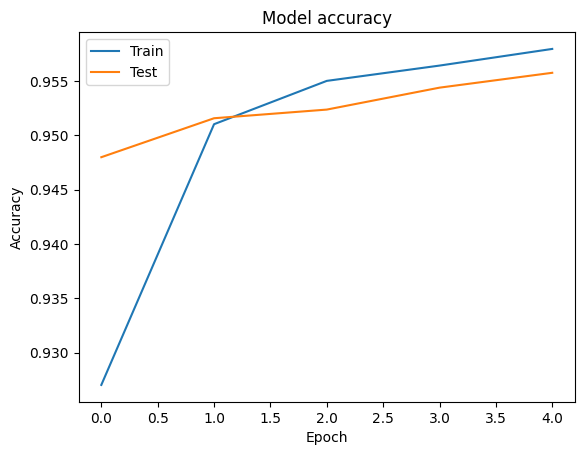

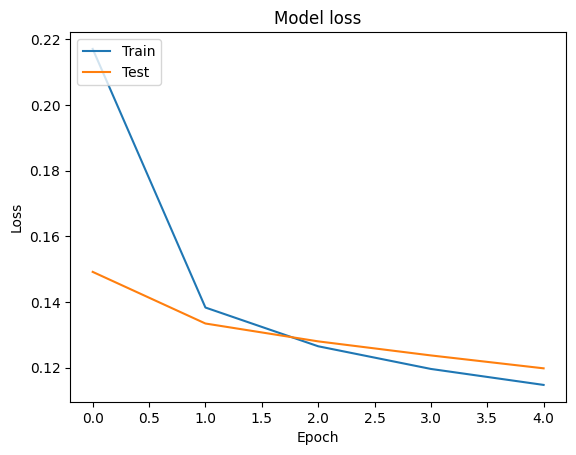

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 예측

검증 데이터에 대한 예측값을 얻고 혼동 행렬을 확인하여 5개 클래스 각각에 대한 모델의 성능을 확인할 수 있습니다. `tf.keras.Model.predict` 메서드는 각 클래스에 대한 확률에 대해 n-d 배열을 반환하므로 `np.argmax`를 사용하여 이를 클래스 레이블로 변환할 수 있습니다.

In [21]:
y_pred = model.predict(validation_data)

  1/294 [..............................] - ETA: 45s

  4/294 [..............................] - ETA: 5s 

  7/294 [..............................] - ETA: 5s

 10/294 [>.............................] - ETA: 4s

 13/294 [>.............................] - ETA: 4s

 16/294 [>.............................] - ETA: 4s

 19/294 [>.............................] - ETA: 4s

 22/294 [=>............................] - ETA: 4s

 25/294 [=>............................] - ETA: 4s

 28/294 [=>............................] - ETA: 4s

 31/294 [==>...........................] - ETA: 4s

 34/294 [==>...........................] - ETA: 4s

 37/294 [==>...........................] - ETA: 4s

 40/294 [===>..........................] - ETA: 4s

 44/294 [===>..........................] - ETA: 4s

 47/294 [===>..........................] - ETA: 4s

 51/294 [====>.........................] - ETA: 4s

 55/294 [====>.........................] - ETA: 4s

 58/294 [====>.........................] - ETA: 3s

 62/294 [=====>........................] - ETA: 3s

 66/294 [=====>........................] - ETA: 3s

 70/294 [======>.......................] - ETA: 3s

 73/294 [======>.......................] - ETA: 3s

 76/294 [======>.......................] - ETA: 3s

 80/294 [=======>......................] - ETA: 3s

 84/294 [=======>......................] - ETA: 3s

 87/294 [=======>......................] - ETA: 3s

 90/294 [========>.....................] - ETA: 3s

 93/294 [========>.....................] - ETA: 3s

 96/294 [========>.....................] - ETA: 3s

 99/294 [=========>....................] - ETA: 3s

103/294 [=========>....................] - ETA: 3s

106/294 [=========>....................] - ETA: 3s

109/294 [==========>...................] - ETA: 3s

113/294 [==========>...................] - ETA: 3s

117/294 [==========>...................] - ETA: 2s

121/294 [===========>..................] - ETA: 2s

125/294 [===========>..................] - ETA: 2s

129/294 [============>.................] - ETA: 2s

132/294 [============>.................] - ETA: 2s

136/294 [============>.................] - ETA: 2s

140/294 [=============>................] - ETA: 2s

144/294 [=============>................] - ETA: 2s

147/294 [==============>...............] - ETA: 2s

151/294 [==============>...............] - ETA: 2s

155/294 [==============>...............] - ETA: 2s

158/294 [===============>..............] - ETA: 2s

162/294 [===============>..............] - ETA: 2s

165/294 [===============>..............] - ETA: 2s

168/294 [================>.............] - ETA: 2s

172/294 [================>.............] - ETA: 2s

176/294 [================>.............] - ETA: 1s

180/294 [=================>............] - ETA: 1s

183/294 [=================>............] - ETA: 1s

187/294 [==================>...........] - ETA: 1s

191/294 [==================>...........] - ETA: 1s

195/294 [==================>...........] - ETA: 1s

198/294 [===================>..........] - ETA: 1s

202/294 [===================>..........] - ETA: 1s

205/294 [===================>..........] - ETA: 1s

209/294 [====================>.........] - ETA: 1s

212/294 [====================>.........] - ETA: 1s

215/294 [====================>.........] - ETA: 1s

218/294 [=====================>........] - ETA: 1s

222/294 [=====================>........] - ETA: 1s

226/294 [======================>.......] - ETA: 1s

230/294 [======================>.......] - ETA: 1s

234/294 [======================>.......] - ETA: 0s

238/294 [=======================>......] - ETA: 0s

242/294 [=======================>......] - ETA: 0s

246/294 [========================>.....] - ETA: 0s

249/294 [========================>.....] - ETA: 0s

252/294 [========================>.....] - ETA: 0s

256/294 [=========================>....] - ETA: 0s

260/294 [=========================>....] - ETA: 0s

263/294 [=========================>....] - ETA: 0s

267/294 [==========================>...] - ETA: 0s

270/294 [==========================>...] - ETA: 0s

274/294 [==========================>...] - ETA: 0s

278/294 [===========================>..] - ETA: 0s

281/294 [===========================>..] - ETA: 0s

285/294 [============================>.] - ETA: 0s

288/294 [============================>.] - ETA: 0s

292/294 [============================>.] - ETA: 0s

294/294 [==============================] - 5s 17ms/step


In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


গত বছরের নভেম্বর মাসে রাজু চৌধুরীর ‘এক মিনিট’ ছবির শুটিংয়ে অংশ নেন শিরিন শিলা। এর মধ্যে নতুন আর কে
True Class:  entertainment
Predicted Class:  state

চট্টগ্রাম কেন্দ্রীয় কারাগারে পানির হাহাকারে থাকা বন্দীদের খোঁজ নিতে গতকাল বুধবার ভিড় করেছে তাঁদের
True Class:  state
Predicted Class:  state

ফুটবল মাঠে আতঙ্কের নতুন নাম আতশবাজি! প্রতিপক্ষ খেলোয়াড়দের লক্ষ্য করে আতশবাজি ছোড়ার কারণে বন্ধ হয়ে
True Class:  sports
Predicted Class:  state


## 성능 비교

이제 `labels`에서 검증 데이터의 올바른 레이블을 가져와 예측값과 비교하고 [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)를 생성합니다. 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.82      0.78      0.80      3897
       sports       0.98      0.98      0.98     10204
entertainment       0.91      0.94      0.92      6256
        state       0.97      0.97      0.97     48512
international       0.91      0.94      0.92      6377

     accuracy                           0.96     75246
    macro avg       0.92      0.92      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



또한 모델의 성능을 0.96 정밀도를 가진 원본 [논문](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset)에서 얻은 공개 결과와 비교할 수 있습니다. 원래 저자는 구두점 및 숫자를 삭제하고 가장 빈번한 25개의 제외어를 제거하는 등 데이터세트에 수행된 많은 전처리 스텝을 설명했습니다. `classification_report`에서 볼 수 있듯이 전처리 없이 5개 epoch 동안만 훈련한 후에도 0.96의 정밀도와 정확도가 얻어집니다!

이 예제에서는 임베딩 모듈에서 Keras 레이어를 만들 때 매개변수 `trainable=False`를 설정했습니다. 이것은 임베딩 가중치가 훈련 중에 업데이트되지 않음을 의미합니다. 이 데이터세트에서 단 두 번의 epoch로 약 97%의 정확도에 도달하려면 `True`로 설정해 보세요. 